In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import magic
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import pickle

In [43]:
plt.rcParams["figure.figsize"] = (15,5)

In [12]:
expression_network_log = pd.read_csv("../../CAR_data/log_sc_expr_with_celltypes.csv", index_col=0)
expression_marker_log = pd.read_csv("../../CAR_data/marker_genes_log_sc_expr_with_celltypes.csv", index_col=0)
expression_housekeeping_log = pd.read_csv("../../CAR_data/log_expr_housekeeping_genes.csv", index_col=0)
raw_counts = pd.read_csv("../../CAR_data/raw_counts_post_qc_genes_of_interest_celltypes.csv")
poissonised_data = pd.read_csv("../../CAR_data/log_sc_expr_with_celltypes_with_noise.csv")

expression_log = expression_network_log.copy()
for c in expression_marker_log.columns:
    if c not in expression_network_log.columns:
        expression_log[c] = expression_marker_log[c]
for c in expression_housekeeping_log.columns:
    if c not in expression_network_log.columns:
        expression_log[c] = expression_housekeeping_log[c]
expression_log
        

CD28      PI3K       Lck      Grb2      GADS  \
AAACGAAAGGTAAGGA-1-1    0.217948  0.396791  0.900622  1.081187  0.396791   
AAACGAAGTACGCGTC-1-1    0.000000  0.000000  0.000000  1.348236  1.902295   
AAACGCTGTGTTCCAA-1-1    0.000000  0.000000  1.290507  1.133884  1.133884   
AAAGAACGTTACCTTT-1-1    0.000000  0.000000  0.790086  0.790086  1.651070   
AAAGGATAGTCTTCCC-1-1    0.164862  0.000000  0.960528  0.889473  1.026868   
...                          ...       ...       ...       ...       ...   
TTGTTGTTCCTAGCCT-1-TCR  0.000000  0.401374  1.243976  0.401374  1.243976   
TTGTTTGTCTATGCCC-1-TCR  0.000000  0.000000  1.908627  0.000000  0.000000   
TTTACCAGTCTGTGAT-1-TCR  0.000000  1.253120  0.000000  1.253120  0.000000   
TTTACGTTCACTTTGT-1-TCR  0.259640  0.000000  1.215419  1.377413  0.782006   
TTTCGATTCACCTTGC-1-TCR  0.000000  0.837663  1.595923  1.595923  0.000000   

                             Akt     ERK12     GSK3b      CD3z     PLCg1  ...  \
AAACGAAAGGTAAGGA-1-1    0.548449  0.000000  0.217948  1.483719  0.000000  ...   
AAACGAAGTACGCGTC-1-1    0.000000  0.000000  0.000000  0.000000  0.000000  ...   
AAACGCTGTGTTCCAA-1-1    0.719717  0.423257  0.000000  1.290507  0.719717  ...   
AAAGAACGTTACCTTT-1-1    0.000000  0.471124  0.471124  1.651070  0.790086  ...   
AAAGGATAGTCTTCCC-1-1    0.000000  0.812979  0.000000  1.482827  0.306353  ...   
...                          ...       ...       ...       ...       ...  ...   
TTGTTGTTCCTAGCCT-1-TCR  0.000000  0.908915  0.000000  0.908915  0.000000  ...   
TTGTTTGTCTATGCCC-1-TCR  0.000000  0.000000  1.069735  1.908627  1.069735  ...   
TTTACCAGTCTGTGAT-1-TCR  0.000000  0.811208  0.000000  0.811208  0.811208  ...   
TTTACGTTCACTTTGT-1-TCR  0.000000  0.636254  0.465573  1.299693  0.259640  ...   
TTTCGATTCACCTTGC-1-TCR  0.000000  0.837663  1.287004  2.022183  0.000000  ...   

                        HLA-DRB5  HLA-DQA1  HLA-DRB1  HLA-DQB1      ACTB  \
AAACGAAAGGTAAGGA-1-1    0.217948  0.000000  0.217948  0.000000  3.625097   
AAACGAAGTACGCGTC-1-1    1.348236  0.000000  0.000000  0.000000  4.240104   
AAACGCTGTGTTCCAA-1-1    0.000000  0.423257  0.000000  0.423257  4.355826   
AAAGAACGTTACCTTT-1-1    1.031539  0.471124  1.528393  1.651070  4.589960   
AAAGGATAGTCTTCCC-1-1    0.000000  0.000000  0.000000  0.000000  4.341395   
...                          ...       ...       ...       ...       ...   
TTGTTGTTCCTAGCCT-1-TCR  1.090413  1.494505  1.694676  1.781500  5.011638   
TTGTTTGTCTATGCCC-1-TCR  0.000000  0.000000  0.000000  1.574684  4.831904   
TTTACCAGTCTGTGAT-1-TCR  0.000000  0.000000  0.000000  0.000000  4.245410   
TTTACGTTCACTTTGT-1-TCR  1.123384  0.782006  1.798383  1.516787  4.651692   
TTTCGATTCACCTTGC-1-TCR  0.000000  0.000000  0.000000  0.837663  3.875246   

                           RPS18    UBE2D2     RPLP0       B2M     PTPRC  
AAACGAAAGGTAAGGA-1-1    3.939815  1.426906  3.333310  3.675706  0.680107  
AAACGAAGTACGCGTC-1-1    4.280349  2.256738  3.384603  4.460362  1.348236  
AAACGCTGTGTTCCAA-1-1    4.145945  1.133884  3.451944  4.421253  1.991035  
AAAGAACGTTACCTTT-1-1    2.697410  1.528393  2.567704  4.234145  2.030740  
AAAGGATAGTCTTCCC-1-1    3.959655  1.147646  2.949809  3.952796  2.100375  
...                          ...       ...       ...       ...       ...  
TTGTTGTTCCTAGCCT-1-TCR  3.246250  1.377066  2.514396  3.909895  2.068666  
TTGTTTGTCTATGCCC-1-TCR  3.568489  0.000000  2.524740  5.086529  2.524740  
TTTACCAGTCTGTGAT-1-TCR  4.208909  1.981433  3.618139  4.208909  2.398350  
TTTACGTTCACTTTGT-1-TCR  4.074318  0.909192  3.412792  3.699562  2.129609  
TTTCGATTCACCTTGC-1-TCR  4.255341  0.000000  3.395887  4.800805  1.831595  

[4751 rows x 192 columns]

In [5]:
genes = list(expression_log.columns)
genes.remove("Type")
genes.remove("CAR_Variant")
genes.remove("cell_type")
genes.remove("NANOG")
genes.remove("GATA1")
genes

['CD28',
 'PI3K',
 'Lck',
 'Grb2',
 'GADS',
 'Akt',
 'ERK12',
 'GSK3b',
 'CD3z',
 'PLCg1',
 'MAPK',
 'mTOR',
 'Bad',
 'cNFkB',
 'NFAT',
 'p38',
 'Bcl2',
 'BclXL',
 'IL10',
 'KLRG1',
 'IRF4',
 'CTLA4',
 'IFNG',
 'LEF1',
 'G0S2',
 'PRDM1',
 'TNFRSF9',
 'TCF7',
 'GZMK',
 'IL13',
 'CDCA2',
 'HAVCR1',
 'LAG3',
 'HAVCR2',
 'CXCL8',
 'ZNF683',
 'FOXP1',
 'IL1B',
 'ID2',
 'CSF2',
 'CDK1',
 'MKI67',
 'GZMB',
 'TNFRSF18',
 'IL17RA',
 'EOMES',
 'CD160',
 'CCL5',
 'IL1A',
 'LAYN',
 'IL7R',
 'LIF',
 'CENPV',
 'CD226',
 'CD69',
 'PDCD1',
 'NCAM1',
 'GNLY',
 'BTLA',
 'CCR7',
 'NKG7',
 'IL2',
 'BATF',
 'CCL1',
 'CD27',
 'CCNA2',
 'STAT1',
 'SELL',
 'CCL3',
 'BATF3',
 '41BB',
 'TRAF1',
 'TRAF2',
 'TRAF3',
 'ncNFkB',
 'ATF2',
 'CEBPB',
 'MEF2A',
 'NFATC1',
 'JUND',
 'FOSL1',
 'ATF1',
 'MEF2C',
 'ELK1',
 'CEBPZ',
 'ESR1',
 'FOS',
 'FOSL2',
 'HSF1',
 'JUN',
 'RXRA',
 'TAL1',
 'BCL3',
 'ELK4',
 'GATA2',
 'MYC',
 'SP1',
 'ETS1',
 'IRF3',
 'STAT3',
 'GABPA',
 'REST',
 'E2F4',
 'CD40',
 'TRAF6',
 'JAK3',
 'ST

<AxesSubplot:xlabel='CD4', ylabel='CD8B'>

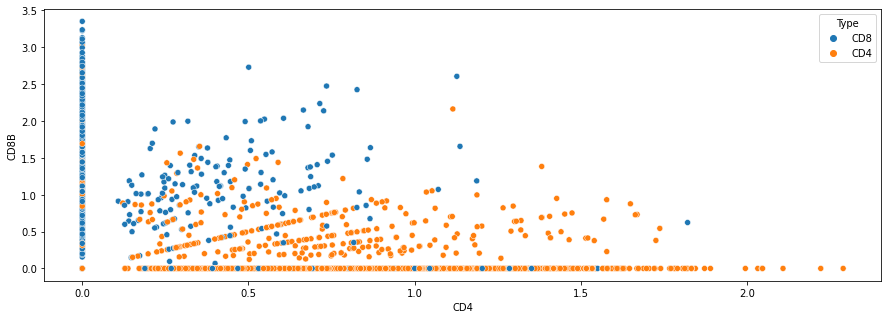

In [11]:
# See if we can superimpose the clusters one over the other
plt.figure()
sns.scatterplot(data = expression_log, x = "CD4", y="CD8B", hue = "Type")

<AxesSubplot:xlabel='CD4', ylabel='CD8B'>

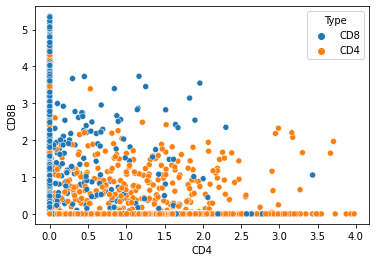

In [24]:
plt.figure()
sns.scatterplot(data = poissonised_data, x = "CD4", y="CD8B", hue = "Type")

Calculating MAGIC...
  Running MAGIC on 4751 cells and 187 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.12 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.88 seconds.
    Calculating affinities...
    Calculated affinities in 2.86 seconds.
  Calculated graph and diffusion operator in 5.88 seconds.
  Calculating imputation...
    Automatically selected t = 9
  Calculated imputation in 0.53 seconds.
Calculated MAGIC in 6.42 seconds.


<AxesSubplot:xlabel='FOS', ylabel='ATF1'>

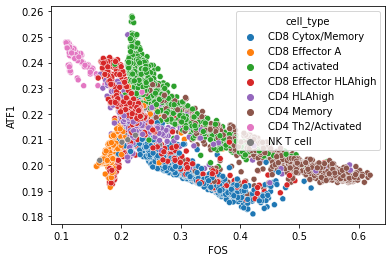

In [40]:
# Try different magic imputations

expression_magicked = expression_log.copy()

magic_operator = magic.MAGIC(t = "auto", verbose=True, random_state=1)
expression_magicked[genes] = magic_operator.fit_transform(expression_log[genes], genes="all_genes")

# See if we can superimpose the clusters one over the other
plt.figure()
sns.scatterplot(data = expression_magicked, x = "FOS", y="ATF1", hue = "cell_type")
#magicked_df[1] = expression_magicked


<AxesSubplot:xlabel='FOS', ylabel='JUN'>

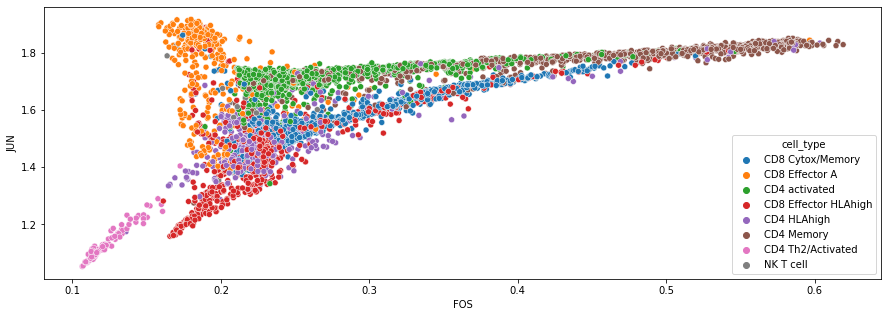

In [8]:
plt.figure()
sns.scatterplot(data = expression_magicked, x = "FOS", y="JUN", hue = "cell_type")

<AxesSubplot:xlabel='MYC', ylabel='RXRA'>

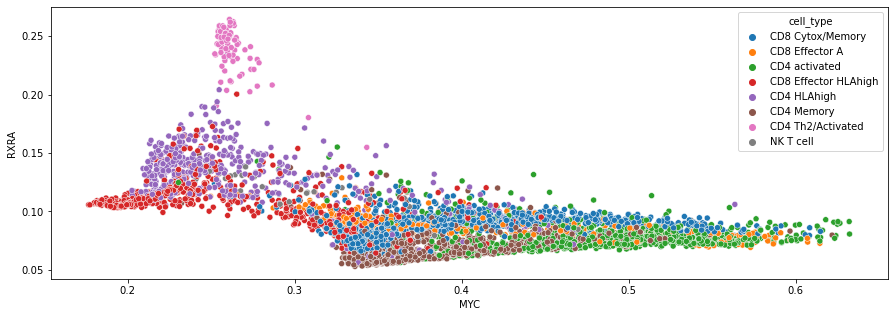

In [9]:
plt.figure()
sns.scatterplot(data = expression_magicked, x = "MYC", y="RXRA", hue = "cell_type")

<AxesSubplot:xlabel='CD4', ylabel='CD8B'>

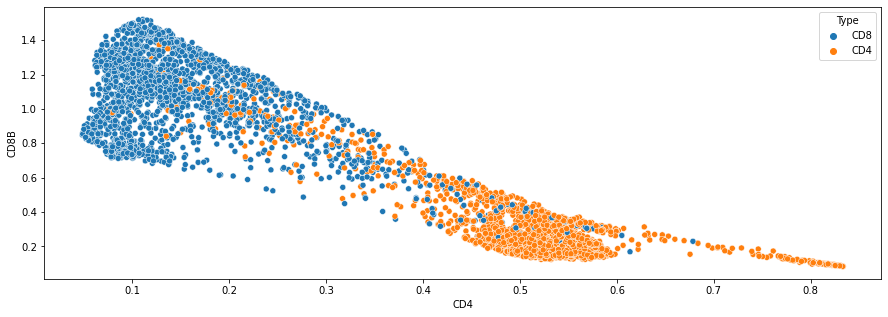

In [10]:
plt.figure()
sns.scatterplot(data = expression_magicked, x = "CD4", y="CD8B", hue = "Type")

Something we might not like: 
    * we have lost the clear distinction between CD4 and CD8

Calculating imputation...
Calculated imputation in 0.03 seconds.
Calculating imputation...
Calculated imputation in 0.03 seconds.
Calculating imputation...
Calculated imputation in 0.04 seconds.
Calculating imputation...
Calculated imputation in 0.05 seconds.
Calculating imputation...
Calculated imputation in 0.07 seconds.
Calculating imputation...
Calculated imputation in 0.08 seconds.
Calculating imputation...
Calculated imputation in 0.09 seconds.
Calculating imputation...
Calculated imputation in 0.11 seconds.
Calculating imputation...
Calculated imputation in 0.12 seconds.
Calculating imputation...
Calculated imputation in 0.15 seconds.
Calculating imputation...
Calculated imputation in 0.18 seconds.
Calculating imputation...
Calculated imputation in 0.19 seconds.
Calculating imputation...
Calculated imputation in 0.21 seconds.
Calculating imputation...
Calculated imputation in 0.22 seconds.


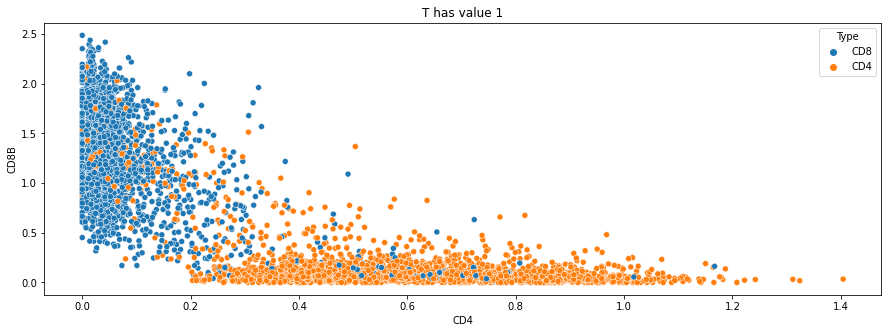

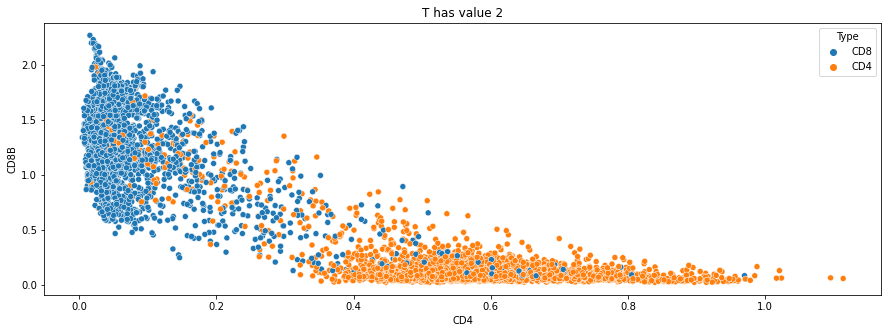

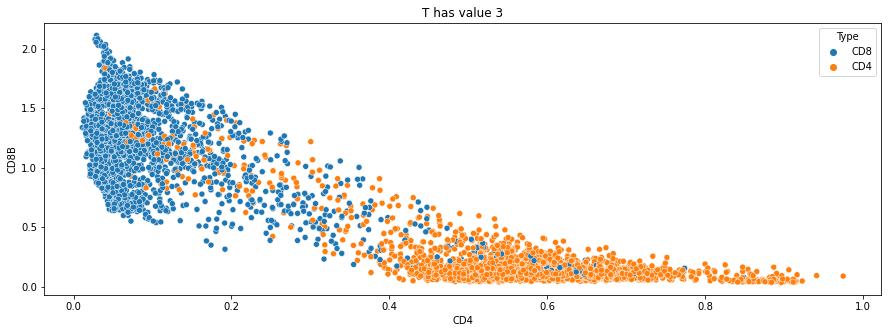

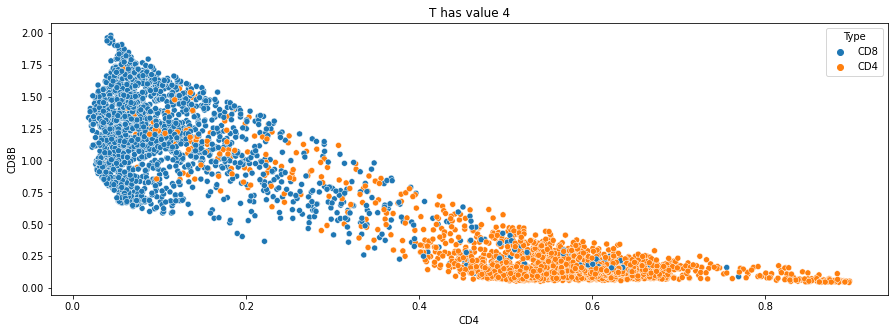

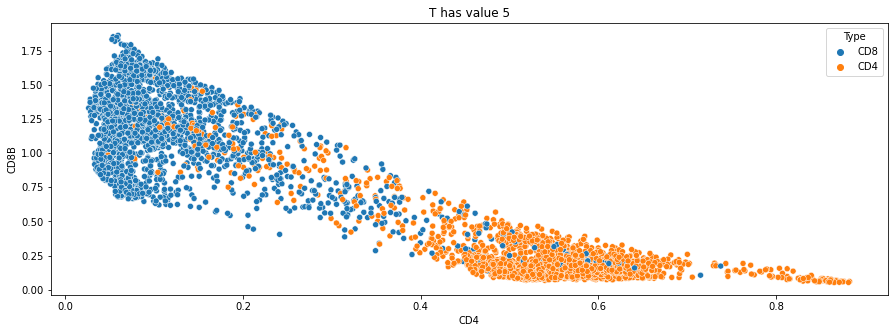

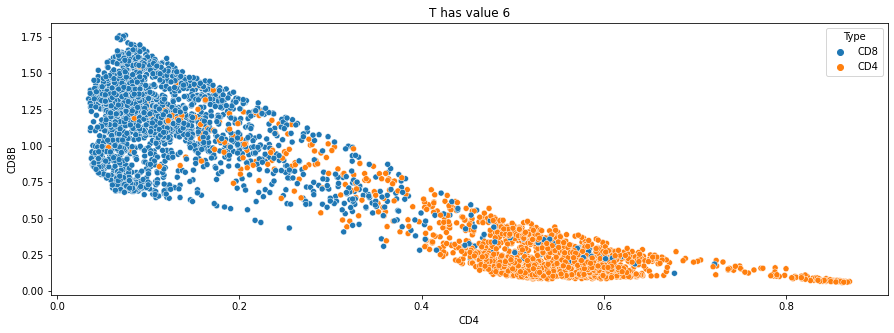

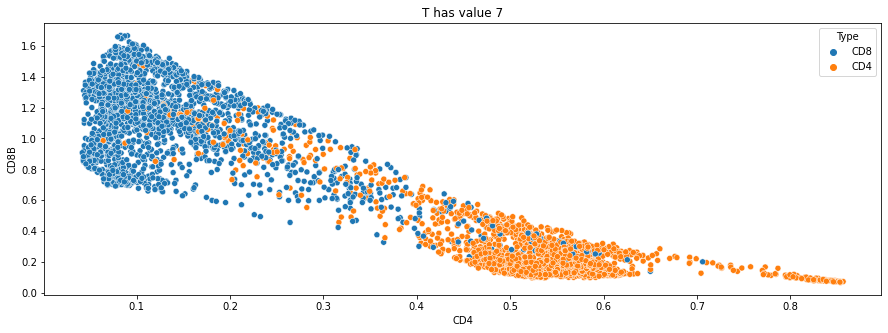

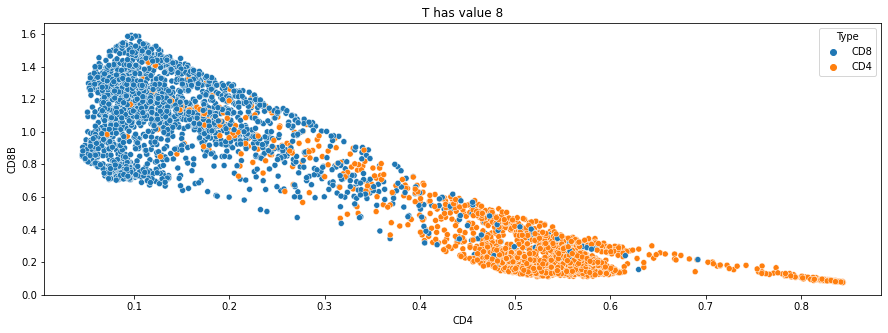

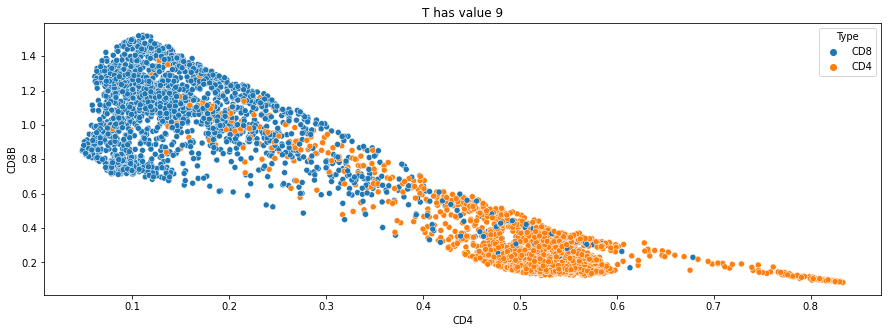

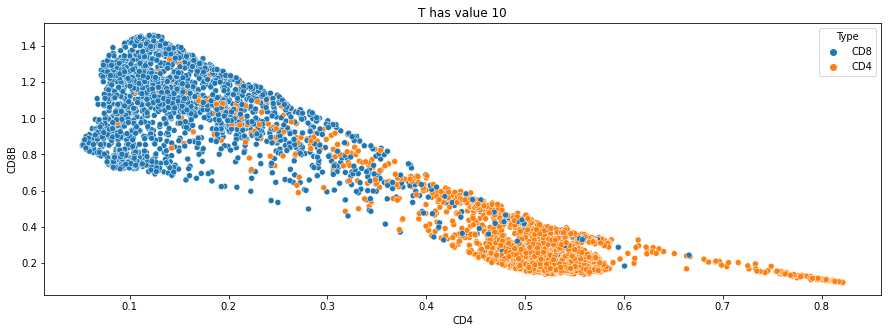

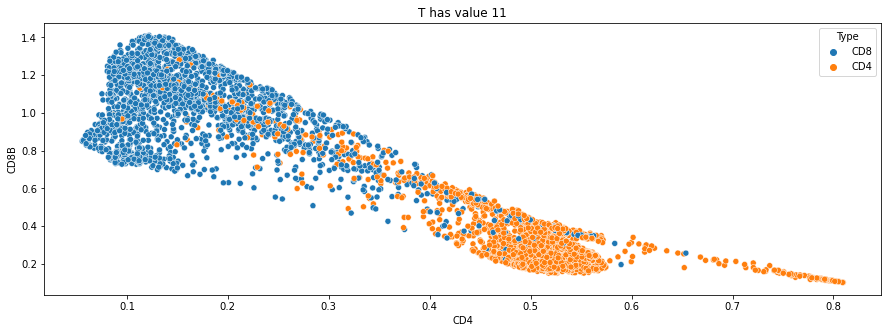

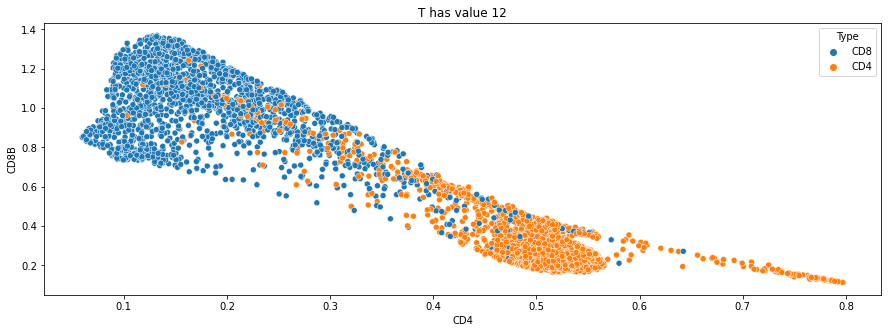

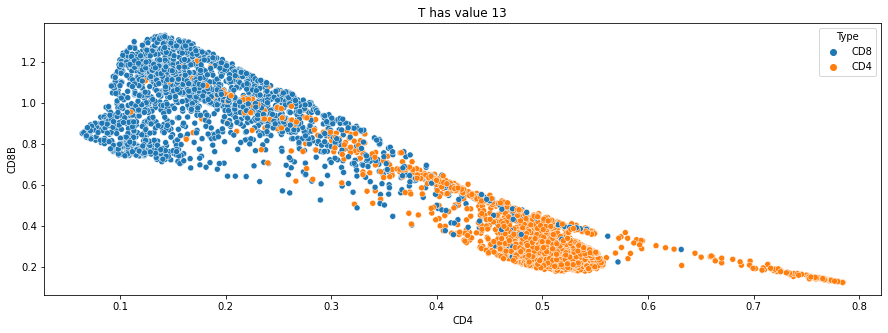

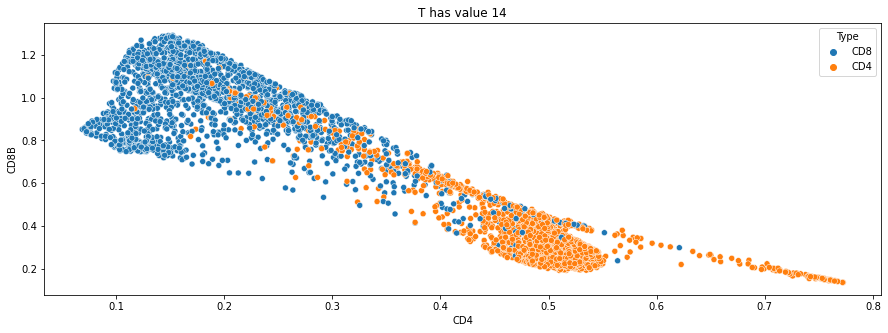

In [11]:
# Explore t values
for i in range(1,15):
    magic_operator.set_params(t = i)
    expression_magicked[genes] = magic_operator.transform(expression_log[genes], genes= "all_genes")
    plt.figure()
    plt.title(f"T has value {i}")
    sns.scatterplot(data = expression_magicked, x = "CD4", y="CD8B", hue = "Type")
    


Empirically, T=6 doesn't seem too bad

# Run the safety check with the imputed values

In [11]:
magic_operator.set_params(t = i)
expression_magicked[genes] = magic_operator.transform(expression_log[genes], genes= "all_genes")

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [11]:
def encode_cell_function(cell_function, cell_functions_list):
    return(cell_functions_list.index(cell_function))

marker_genes = pickle.load(open("../../CAR_data/marker_genes", "rb"))

expression_sc = expression_magicked

all_functions = list(np.unique(expression_sc["cell_type"]))
expression_sc["function_encoded"] = expression_sc["cell_type"].apply(encode_cell_function, args=(all_functions,))

expression_sc_CD4 = expression_sc[expression_sc["Type"]  == 'CD4']
expression_sc_CD8 = expression_sc[expression_sc["Type"]  == 'CD8']

CD4_functions = list(np.unique(expression_sc_CD4["cell_type"]))
CD8_functions = list(np.unique(expression_sc_CD8["cell_type"]))


split = train_test_split(expression_sc, test_size=0.1, random_state=2)
training_set = split[0]
validation_set = split[1]

split_CD4 = train_test_split(expression_sc_CD4, test_size=0.1, random_state=2)
training_set_CD4 = split_CD4[0]
validation_set_CD4 = split_CD4[1]

split_CD8 = train_test_split(expression_sc_CD8, test_size=0.1, random_state=2)
training_set_CD8 = split_CD8[0]
validation_set_CD8 = split_CD8[1]

n_CAR = np.unique(training_set["CAR_Variant"])
print(f"There are {len(n_CAR)}/31 CAR Variants in the mixed training set")
n_CAR_CD4 = np.unique(training_set_CD4["CAR_Variant"])
print(f"There are {len(n_CAR_CD4)}/31 CAR Variants in the CD4 training set")
n_CAR_CD8 = np.unique(training_set_CD8["CAR_Variant"])
print(f"There are {len(n_CAR_CD8)}/31 CAR Variants in the CD8 training set")

training_inputs = training_set[marker_genes]
training_values = training_set["function_encoded"]
validation_inputs = validation_set[marker_genes]
validation_values = validation_set["function_encoded"]

training_inputs_CD4 = training_set_CD4[marker_genes]
training_values_CD4 = training_set_CD4["function_encoded"]
validation_inputs_CD4 = validation_set_CD4[marker_genes]
validation_values_CD4 = validation_set_CD4["function_encoded"]

training_inputs_CD8 = training_set_CD8[marker_genes]
training_values_CD8 = training_set_CD8["function_encoded"]
validation_inputs_CD8 = validation_set_CD8[marker_genes]
validation_values_CD8 = validation_set_CD8["function_encoded"]



There are 31/31 CAR Variants in the mixed training set
There are 31/31 CAR Variants in the CD4 training set
There are 30/31 CAR Variants in the CD8 training set


/tmp/ipykernel_214144/1885614102.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  expression_sc["function_encoded"] = expression_sc["cell_type"].apply(encode_cell_function, args=(all_functions,))


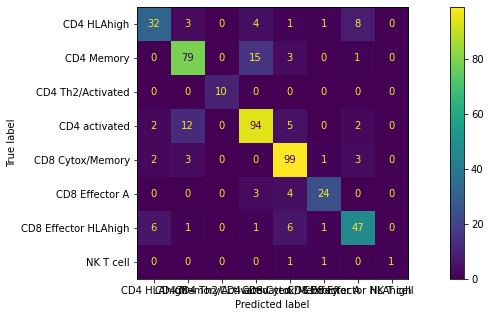

In [12]:
rf = RandomForestClassifier(n_estimators=200, random_state=2)

rf.fit(X = training_inputs, y = training_values)
pred = rf.predict(X = validation_inputs)

# Check what I am predicting with a heatmap of the true counts vs the predicted counts for each class

bincount_pred = np.bincount(pred)
bincount_true = np.bincount(validation_values)

if len (bincount_pred)<8:
    bincount_pred = np.asarray(list(bincount_pred) + [0]) # There may be no NK T cells in the validation set

true_counts = pd.DataFrame({"CD4 HLAhigh": bincount_true[0],
                                "CD4 Memory": bincount_true[1],
                                "CD4 TH2/Activated": bincount_true[2],
                                "CD4 activated": bincount_true[3],
                               "CD8 Cytox/Memory": bincount_true[4],
                                "CD8 Effector A": bincount_true[5],
                                "CD8 Effector HLAhigh": bincount_true[6],
                                "NK T cell": bincount_true[7]                               
                               }, index = [1])


pred_counts = pd.DataFrame({"CD4 HLAhigh": bincount_pred[0],
                                "CD4 Memory": bincount_pred[1],
                                "CD4 TH2/Activated": bincount_pred[2],
                                "CD4 activated": bincount_pred[3],
                               "CD8 Cytox/Memory": bincount_pred[4],
                                "CD8 Effector A": bincount_pred[5],
                                "CD8 Effector HLAhigh": bincount_pred[6],
                                "NK T cell": bincount_pred[7]                               
                               }, index = [1])

cm = confusion_matrix(validation_values, pred, labels=[0,1,2,3,4,5,6,7])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=all_functions)
disp.plot()

It is quite similar to the results obtained with the normalised data so the marker genes 

# Train the baseline random forests for comparison

In [7]:
## Fit a simple regression to each TF and create a dictionary to save the results
## For that I'll need to scale the data

upstream_nodes_dict = pickle.load(open("../../CAR_data/upstream_node_dict", "rb"))


expression_sc = expression_magicked
split = train_test_split(expression_sc, test_size=0.1, random_state=2)
expression_training_sc = split[0]
expression_validation_sc = split[1]



ATF1
ATF2
BCL3
CEBPB
CEBPZ
E2F4
ELK1
ELK4
ESR1
ETS1
FOS
FOSL1
FOSL2
GABPA
GATA1
GATA2
HSF1
IRF3
JUN
JUND
MEF2A
MEF2C
MYC
NANOG
NFAT
NFATC1
REST
RXRA
SP1
STAT1
STAT3
STAT5
TAL1
Bcl2
BclXL
GADS
IFNG
IL2
IL6
TNFa
cmyc
mTOR
ATF1:  (0.9972338179474076, 0.9769286981145054) 
ATF2:  (0.9952998494296745, 0.9591316114477397) 
BCL3:  (0.9989704647855869, 0.9950519083204424) 
CEBPB:  (0.9810354164224317, 0.8723402419199868) 
CEBPZ:  (0.9904459592657542, 0.9422306718641682) 
E2F4:  (0.9996406048014786, 0.9970834040262349) 
ELK1:  (0.9827357505962928, 0.8666938079067831) 
ELK4:  (0.99915545000295, 0.9943089214597487) 
ESR1:  (0.9989072087277987, 0.9943327915208493) 
ETS1:  (0.9982899546263788, 0.9885776976819778) 
FOS:  (0.9998781565876756, 0.9988963516364086) 
FOSL1:  (0.9972628175755615, 0.975126150560054) 
FOSL2:  (0.9977081810686026, 0.9837292484928151) 
GABPA:  (0.9991625653558656, 0.994138427499977) 
GATA1:  (1.0, 1.0) 
GATA2:  (0.9980517515413515, 0.9914081443044055) 
HSF1:  (0.99955335419273

/tmp/ipykernel_111045/3763447294.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


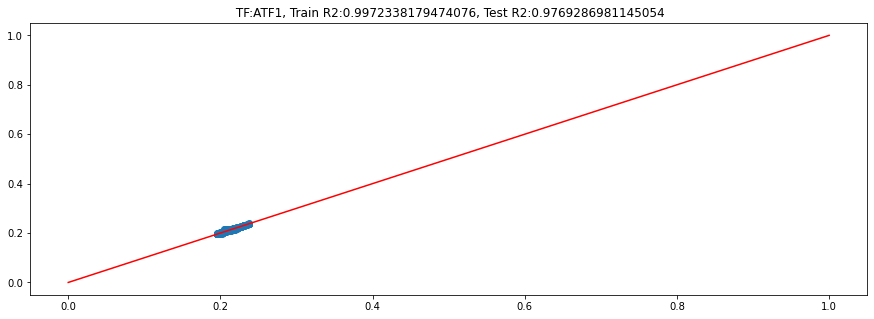

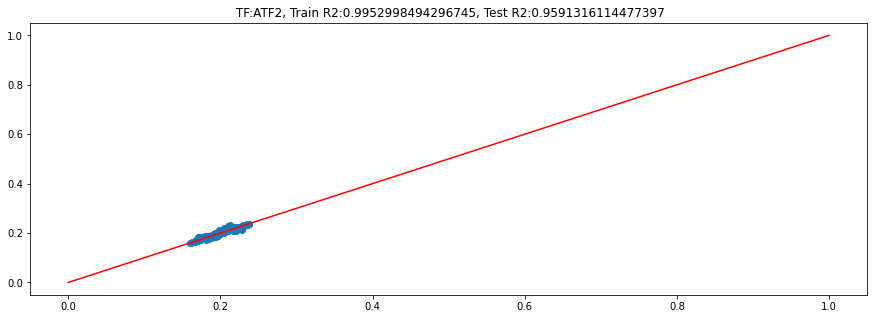

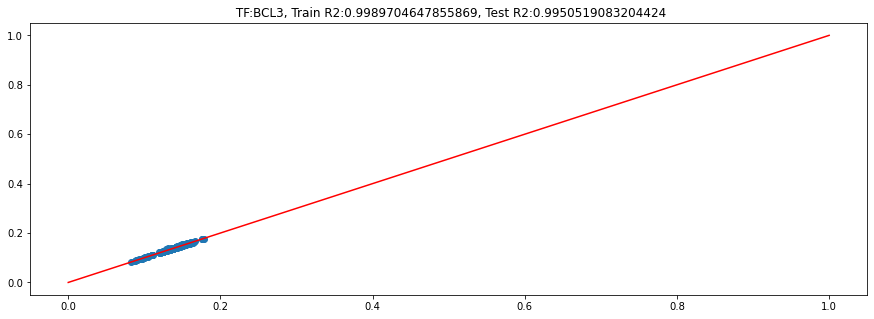

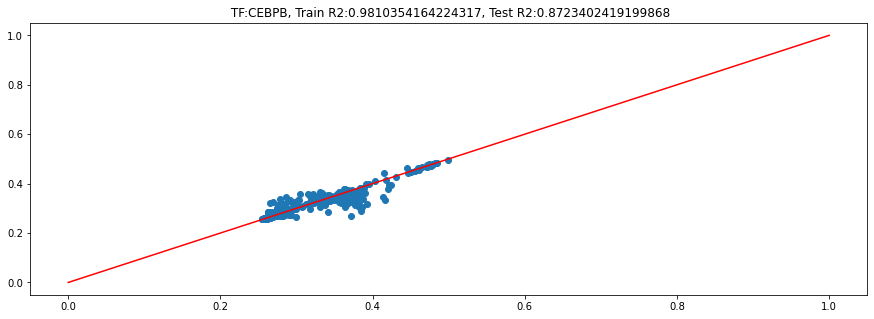

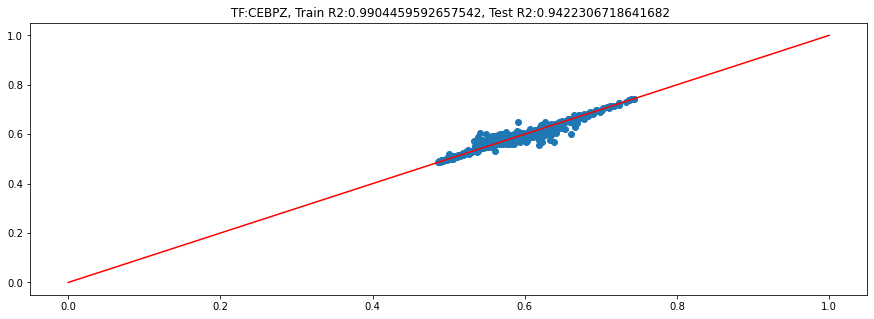

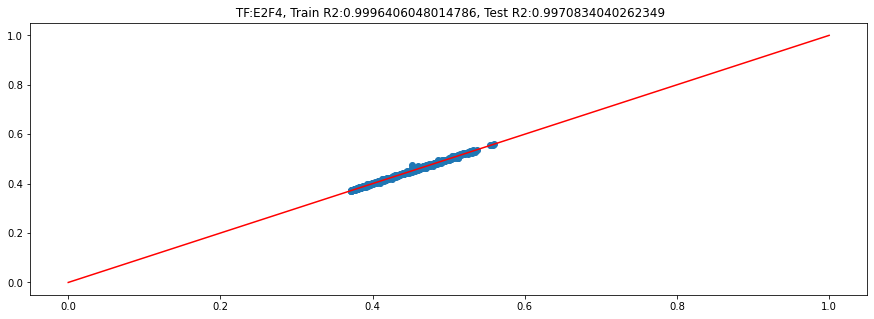

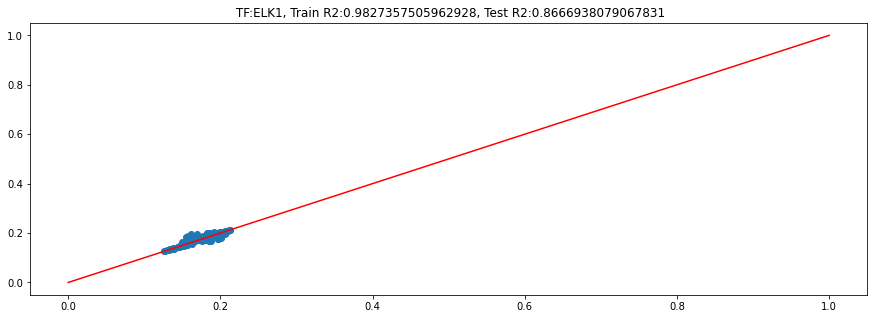

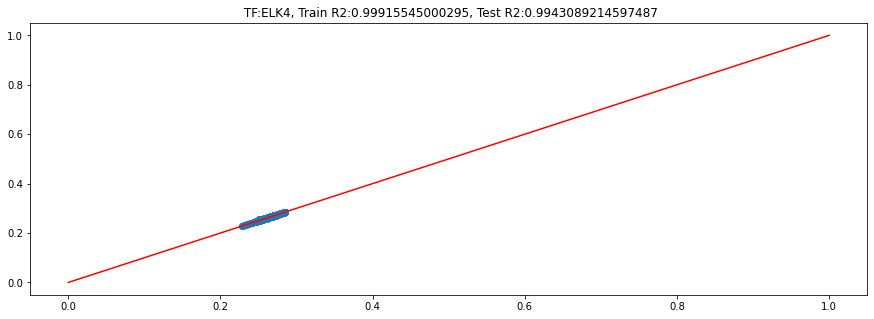

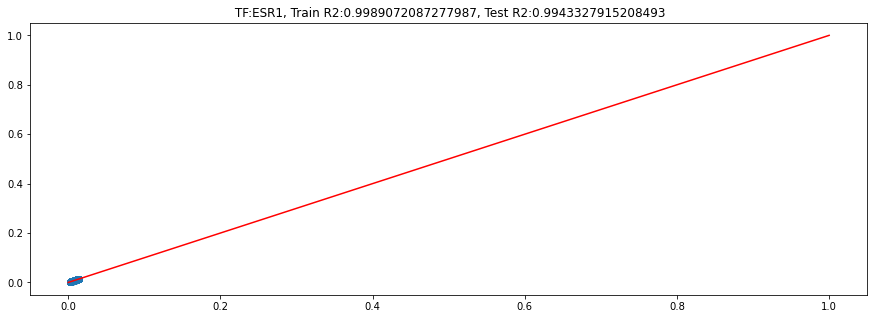

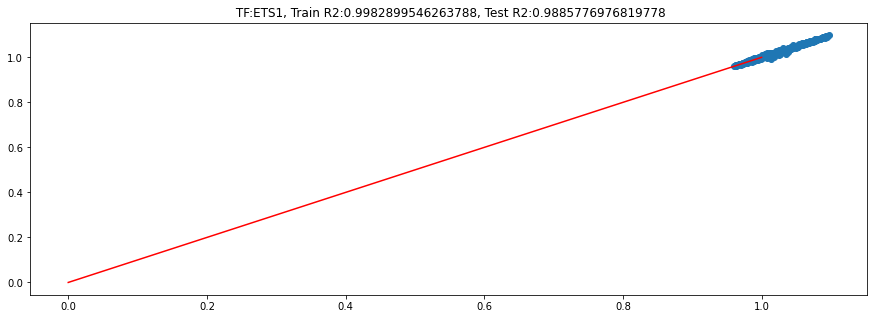

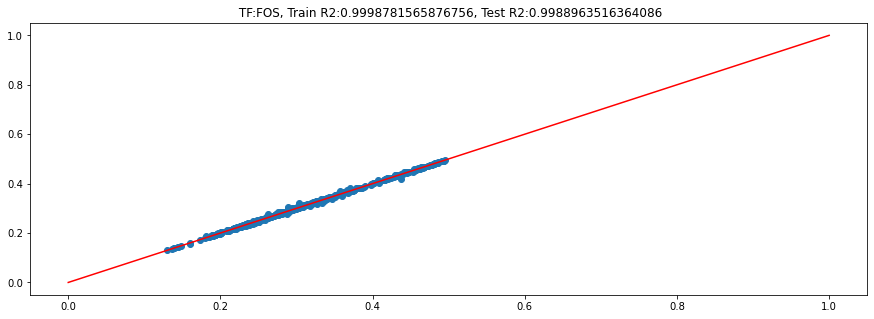

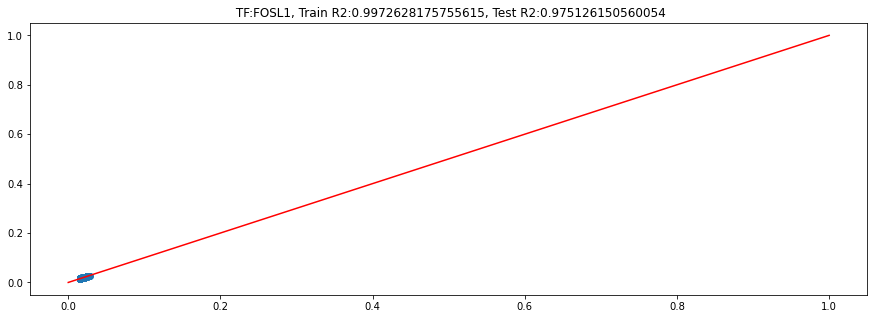

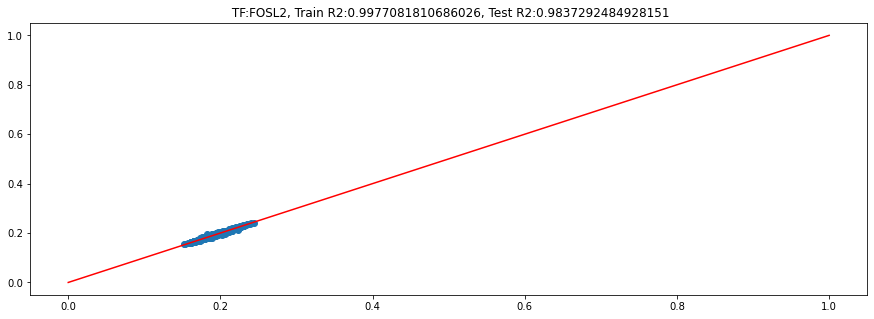

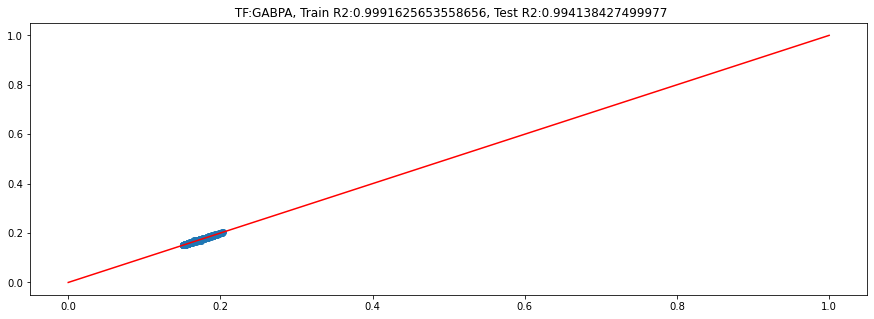

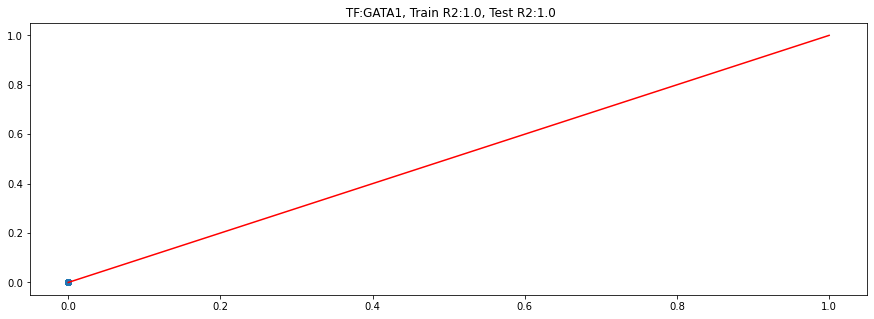

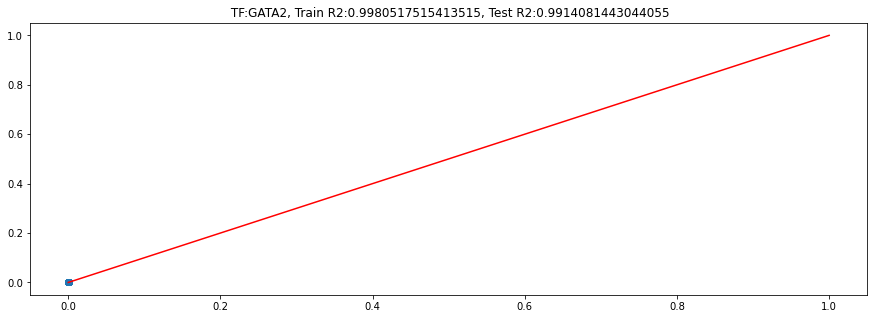

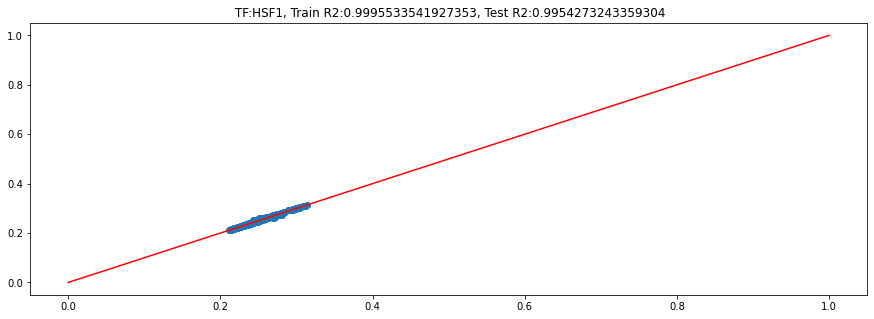

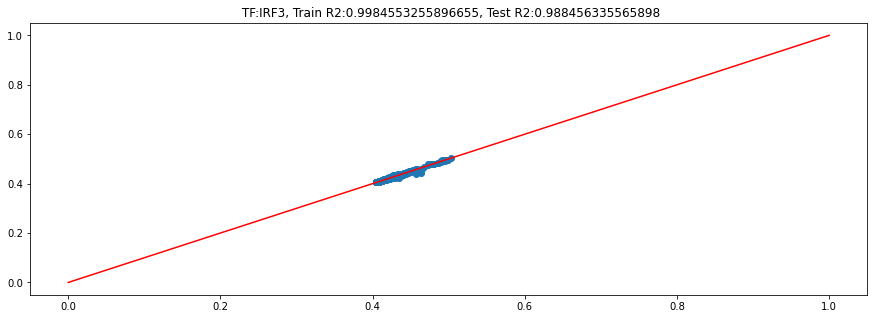

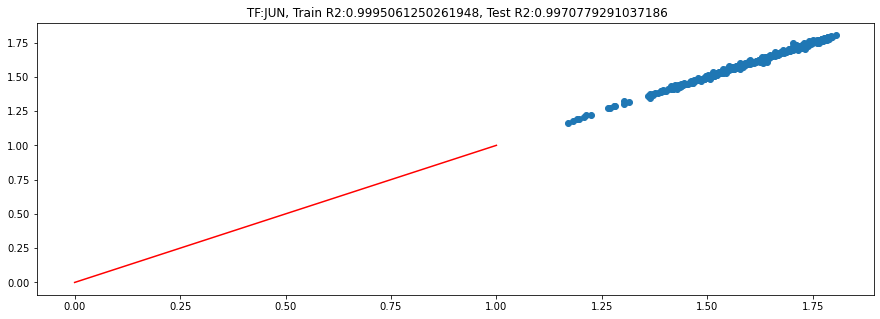

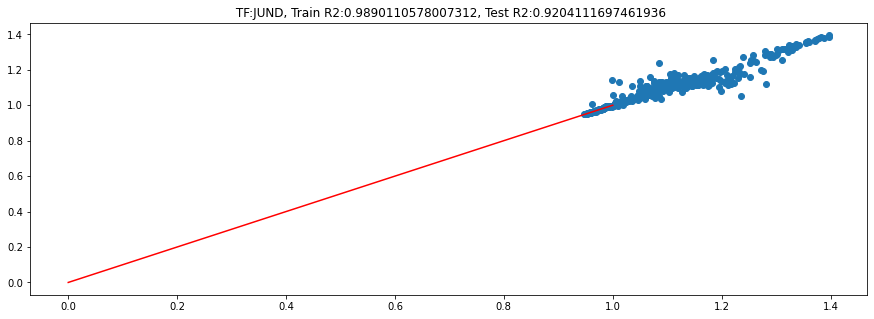

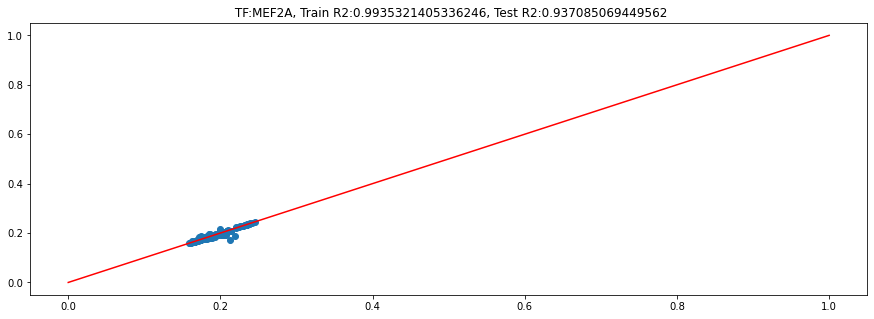

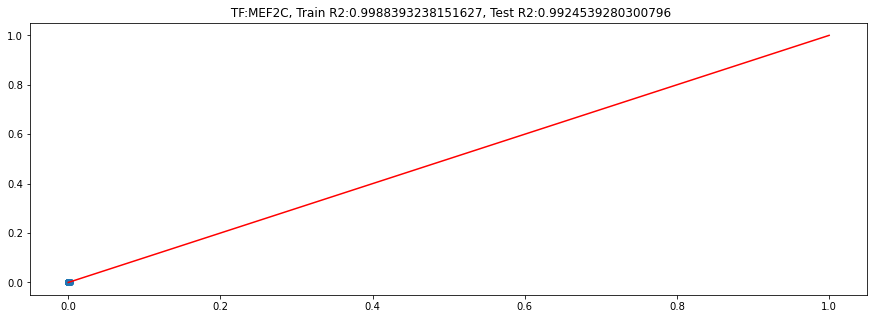

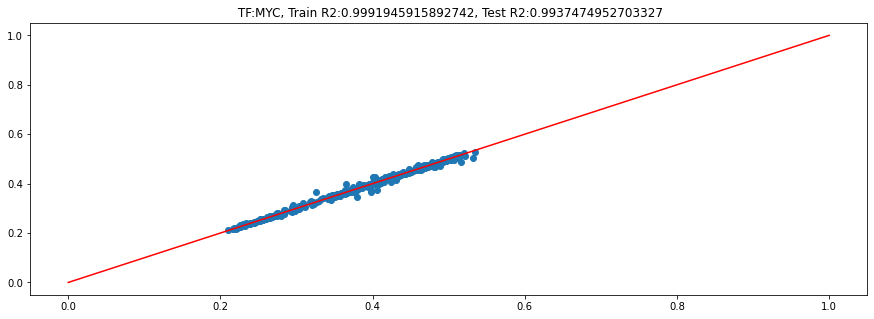

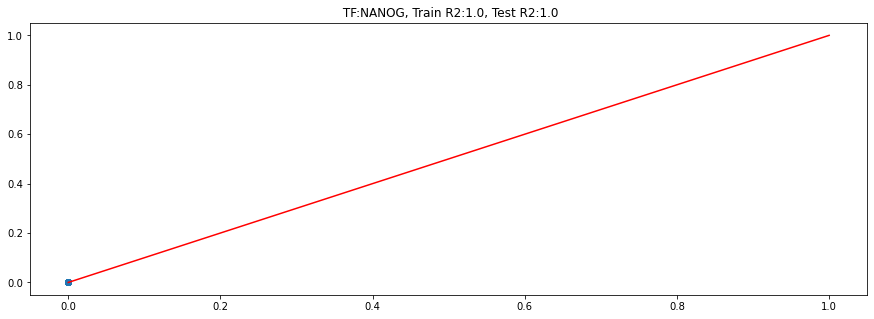

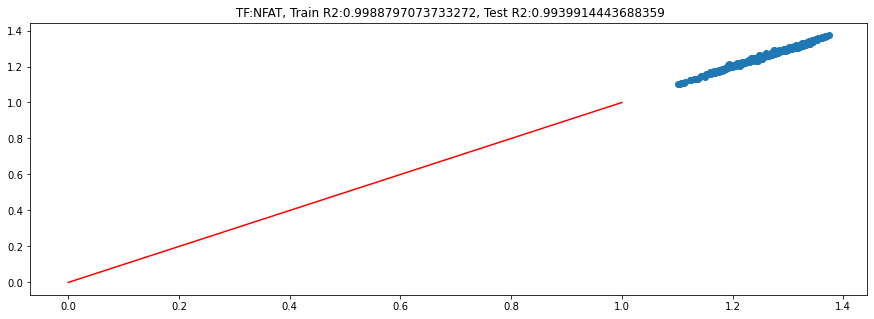

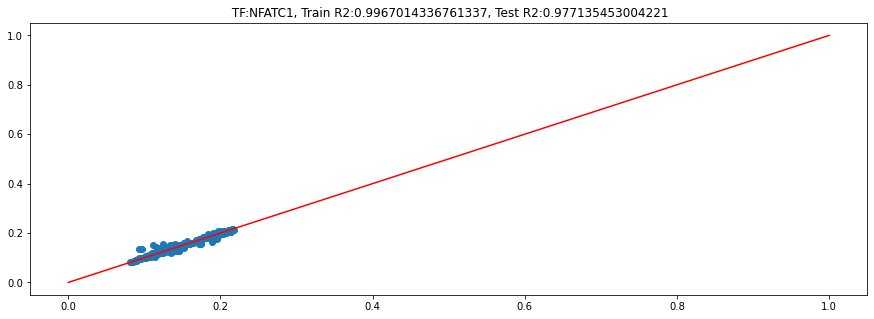

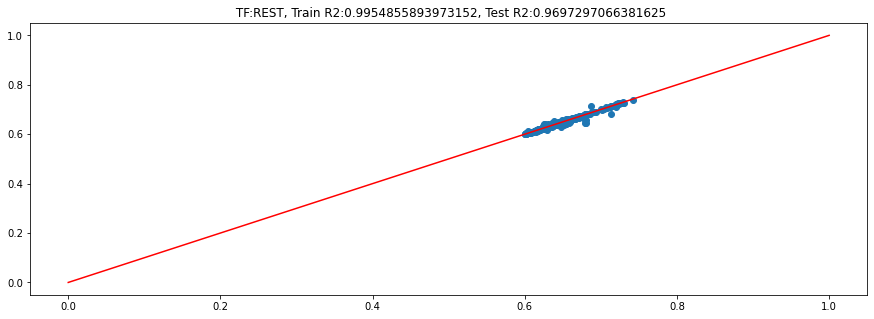

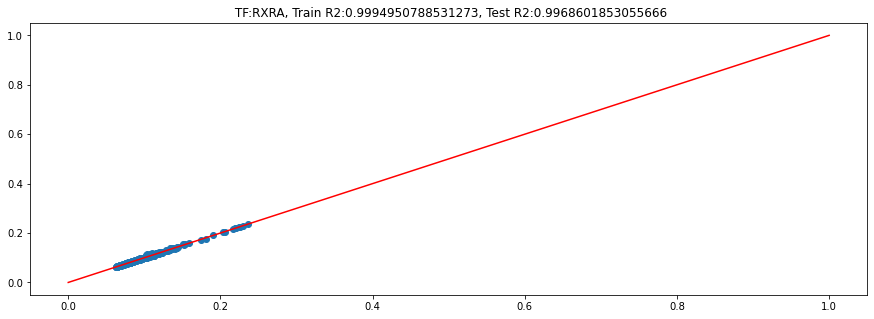

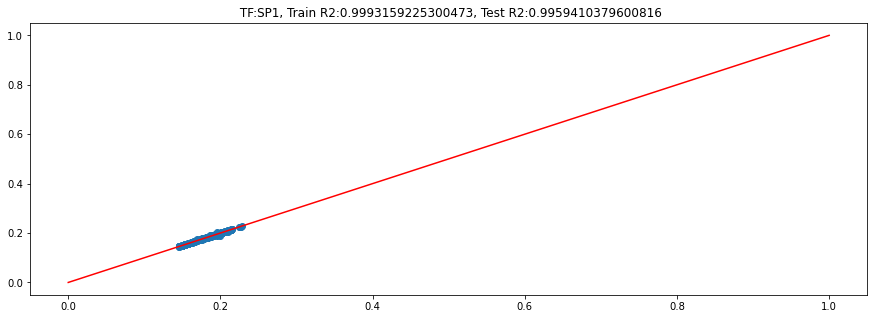

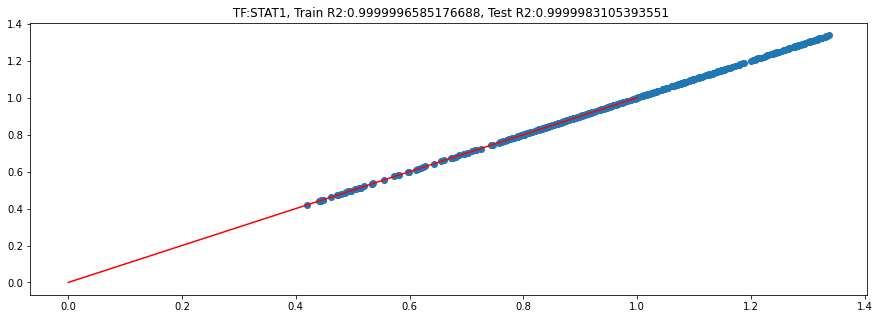

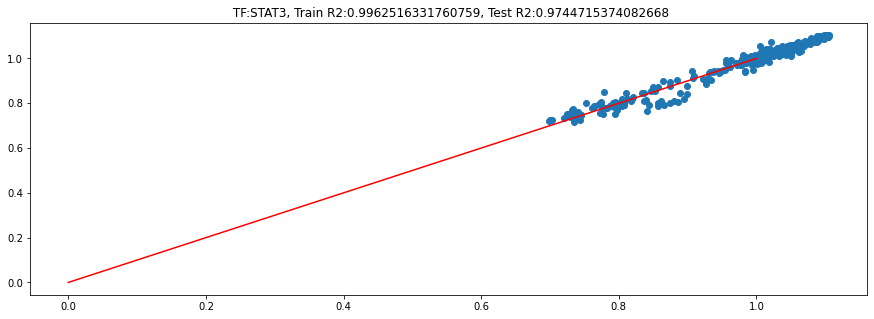

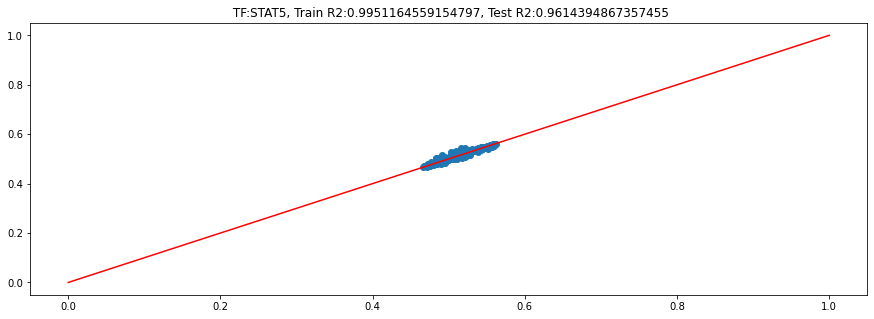

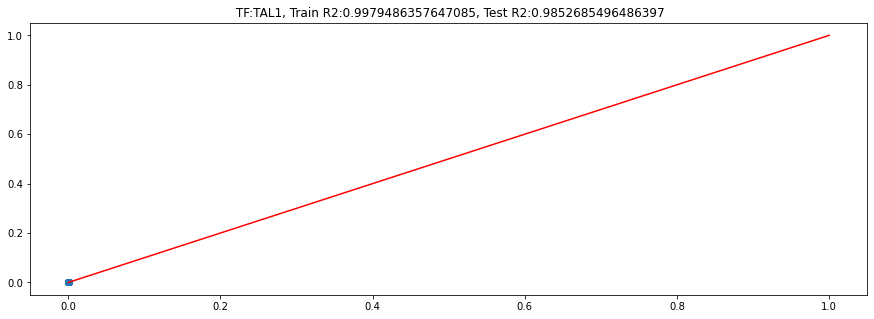

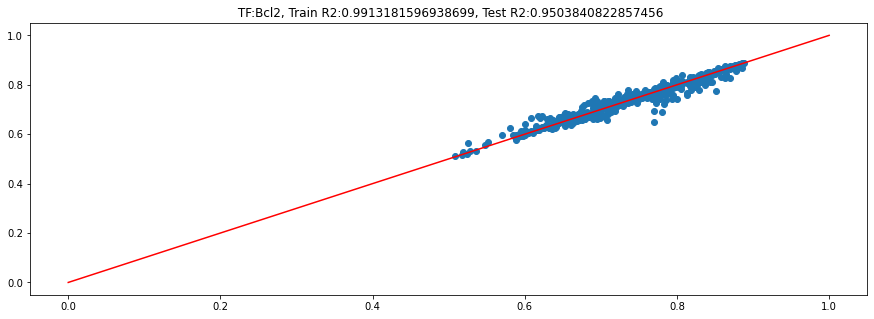

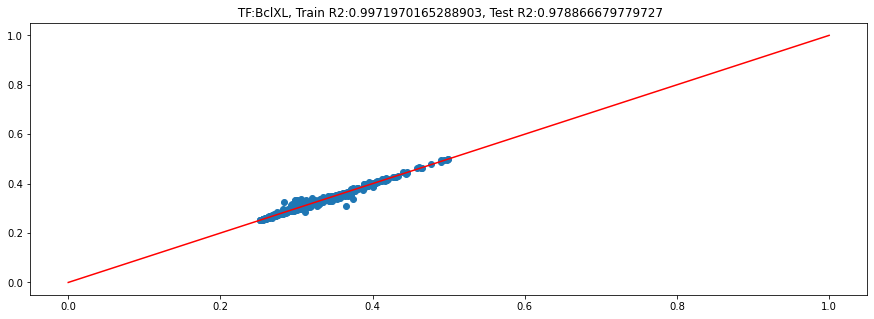

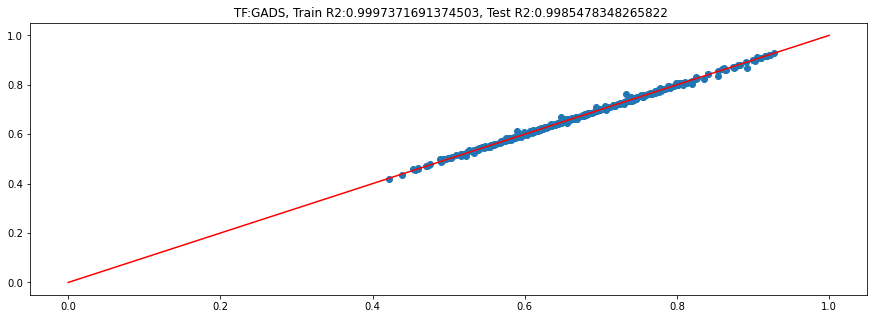

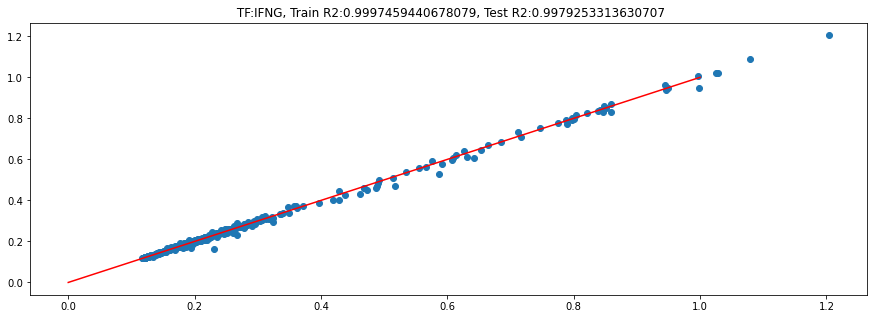

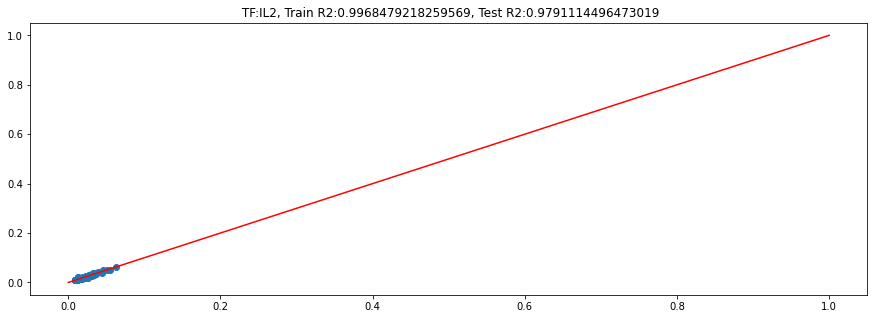

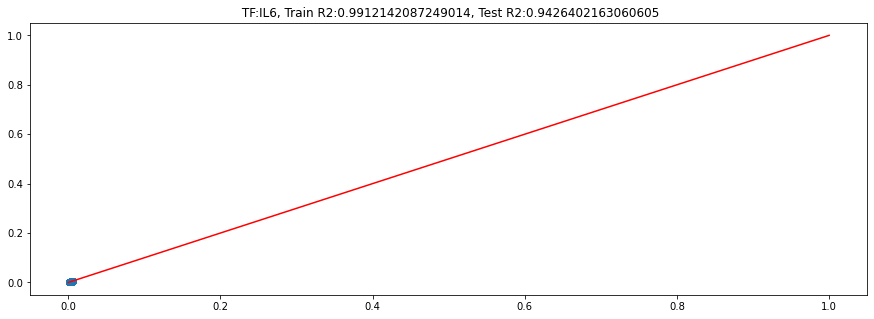

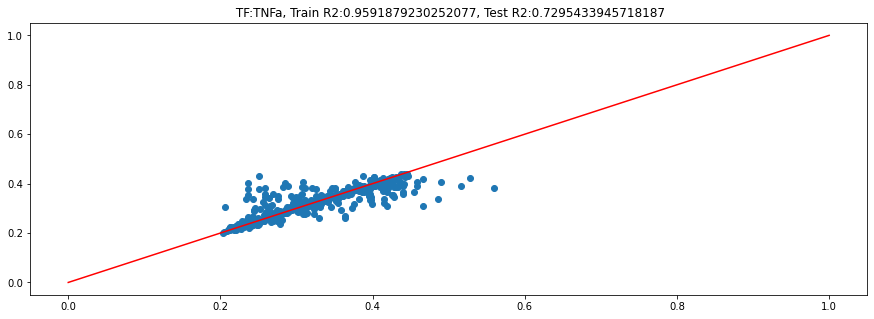

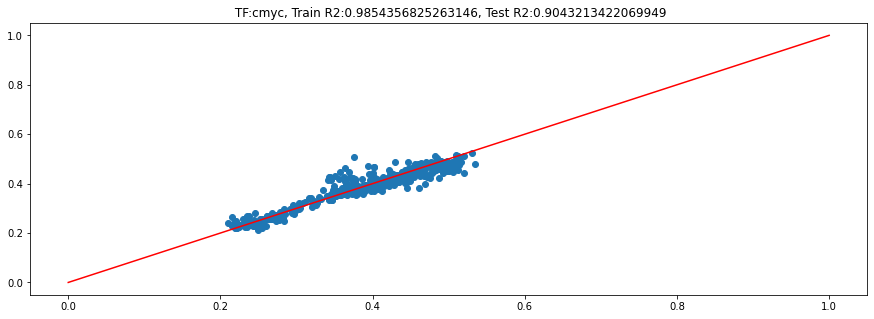

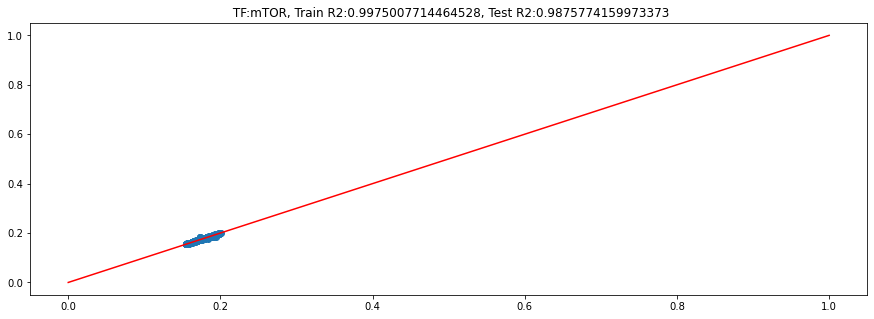

In [18]:



rf_dict = {}
unfit = []
for tf in upstream_nodes_dict:
    print(tf)
    rf = RandomForestRegressor(n_estimators=200, random_state=2)

    try:
        rf.fit(X = expression_training_sc[upstream_nodes_dict[tf]],
               y = expression_training_sc[tf])
        rf_dict[tf] = rf
        
    except:
        print(f"{tf} could not be fit")
        unfit.append(tf)
        
## For each model that was fit: predict and assess fit on the training and validation set

score_dict = {}
prediction_dict = {}
for tf in rf_dict:
    parents = upstream_nodes_dict[tf]
    ypred_test = rf_dict[tf].predict(expression_validation_sc[parents])
    ypred_train = rf_dict[tf].predict(expression_training_sc[parents])

    prediction_dict[tf] = (ypred_train, ypred_test)
    
    score_train = r2_score(y_true=expression_training_sc[tf],
                                         y_pred = ypred_train)
    score_test = r2_score(y_true=expression_validation_sc[tf],
                                         y_pred = ypred_test)
    score_dict[tf] = (score_train, score_test)
    print(f"{tf}:  {score_dict[tf]} ")
    
## Examine all the relationships

for tf in prediction_dict:
    plt.figure()
    plt.scatter(x = expression_validation_sc[tf], y = prediction_dict[tf][1])
    X = np.linspace(0,1)
    plt.plot( X, X, "r")
    plt.title( f" TF:{tf}, Train R2:{score_dict[tf][0]}, Test R2:{score_dict[tf][1]}")




In [20]:
plt.close("all")

Text(0.5, 1.0, ' TF:mTOR, Train R2:0.9900775211919538, Test R2:0.9454591230289682')

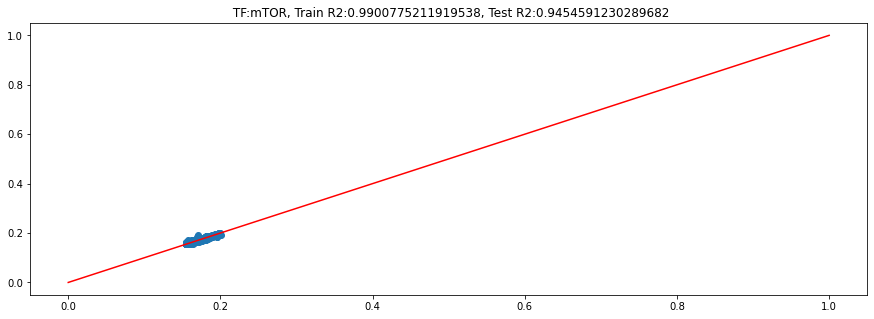

In [31]:
# Sanity check: Regress mTor against the parents of Bcl2

rf = RandomForestRegressor(n_estimators=200, random_state=2)

rf.fit(X = expression_training_sc[upstream_nodes_dict["Bcl2"]],
               y = expression_training_sc["mTOR"])

ypred_test = rf.predict(expression_validation_sc[upstream_nodes_dict["Bcl2"]])
ypred_train = rf.predict(expression_training_sc[upstream_nodes_dict["Bcl2"]])

score_train = r2_score(y_true=expression_training_sc["mTOR"],
                                     y_pred = ypred_train)
score_test = r2_score(y_true=expression_validation_sc["mTOR"],
                                     y_pred = ypred_test)
plt.figure()
plt.scatter(x = expression_validation_sc["mTOR"], y = ypred_test)
X = np.linspace(0,1)
plt.plot( X, X, "r")
plt.title( f" TF:{tf}, Train R2:{score_train}, Test R2:{score_test}")




Text(0.5, 1.0, ' TF:mTOR, Train R2:0.9994108601281204, Test R2:0.9956302425587485')

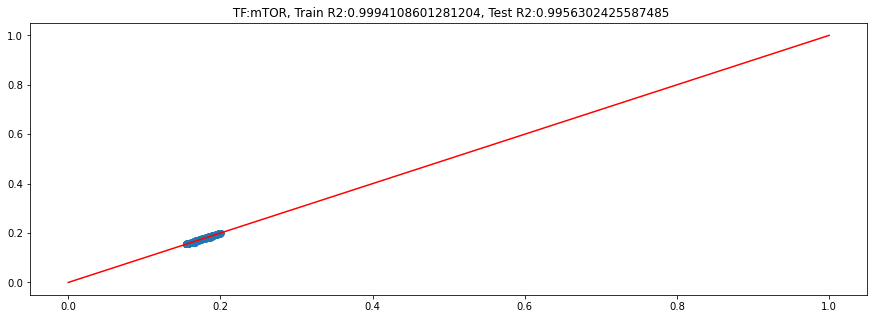

In [32]:
# Sanity check: Regress mTor against the parents of IL2

rf = RandomForestRegressor(n_estimators=200, random_state=2)

rf.fit(X = expression_training_sc[upstream_nodes_dict["IL2"]],
               y = expression_training_sc["mTOR"])

ypred_test = rf.predict(expression_validation_sc[upstream_nodes_dict["IL2"]])
ypred_train = rf.predict(expression_training_sc[upstream_nodes_dict["IL2"]])

score_train = r2_score(y_true=expression_training_sc["mTOR"],
                                     y_pred = ypred_train)
score_test = r2_score(y_true=expression_validation_sc["mTOR"],
                                     y_pred = ypred_test)
plt.figure()
plt.scatter(x = expression_validation_sc["mTOR"], y = ypred_test)
X = np.linspace(0,1)
plt.plot( X, X, "r")
plt.title( f" TF:{tf}, Train R2:{score_train}, Test R2:{score_test}")





In [13]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=2)
grid = GridSearchCV(estimator = rf, param_grid= {"n_estimators":[100, 200,300], "min_samples_leaf":[1,3,5,10],
                                                "ccp_alpha": [0, 0.001, 0.1]}, scoring = "r2", verbose=3)

grid.fit(X = expression_training_sc[upstream_nodes_dict["BCL3"]] , y = expression_training_sc["BCL3"])




Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=100;, score=0.984 total time=   1.3s
[CV 2/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=100;, score=0.985 total time=   1.3s
[CV 3/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=100;, score=0.977 total time=   1.3s
[CV 4/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=100;, score=0.986 total time=   1.2s
[CV 5/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=100;, score=0.981 total time=   1.2s
[CV 1/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=200;, score=0.984 total time=   2.5s
[CV 2/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=200;, score=0.985 total time=   2.5s
[CV 3/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=200;, score=0.978 total time=   2.5s
[CV 4/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=200;, score=0.986 total time=   2.5s
[CV 5/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=200;, score=0.9

[CV 5/5] END ccp_alpha=0.001, min_samples_leaf=3, n_estimators=200;, score=-0.000 total time=   2.4s
[CV 1/5] END ccp_alpha=0.001, min_samples_leaf=3, n_estimators=300;, score=-0.001 total time=   3.7s
[CV 2/5] END ccp_alpha=0.001, min_samples_leaf=3, n_estimators=300;, score=-0.003 total time=   3.6s
[CV 3/5] END ccp_alpha=0.001, min_samples_leaf=3, n_estimators=300;, score=-0.000 total time=   3.6s
[CV 4/5] END ccp_alpha=0.001, min_samples_leaf=3, n_estimators=300;, score=-0.002 total time=   3.5s
[CV 5/5] END ccp_alpha=0.001, min_samples_leaf=3, n_estimators=300;, score=-0.000 total time=   3.7s
[CV 1/5] END ccp_alpha=0.001, min_samples_leaf=5, n_estimators=100;, score=-0.001 total time=   1.0s
[CV 2/5] END ccp_alpha=0.001, min_samples_leaf=5, n_estimators=100;, score=-0.003 total time=   1.0s
[CV 3/5] END ccp_alpha=0.001, min_samples_leaf=5, n_estimators=100;, score=-0.000 total time=   1.0s
[CV 4/5] END ccp_alpha=0.001, min_samples_leaf=5, n_estimators=100;, score=-0.001 total tim

[CV 2/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=100;, score=-0.003 total time=   0.9s
[CV 3/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=100;, score=-0.000 total time=   0.9s
[CV 4/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=100;, score=-0.001 total time=   0.9s
[CV 5/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=100;, score=-0.000 total time=   0.9s
[CV 1/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=200;, score=-0.001 total time=   1.8s
[CV 2/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=200;, score=-0.003 total time=   1.8s
[CV 3/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=200;, score=-0.000 total time=   1.8s
[CV 4/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=200;, score=-0.002 total time=   1.8s
[CV 5/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=200;, score=-0.000 total time=   1.8s
[CV 1/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=300;, score=-0.001 total time=   2.6s


GridSearchCV(estimator=RandomForestRegressor(random_state=2),
             param_grid={'ccp_alpha': [0, 0.001, 0.1],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=3)

In [14]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=2)
grid = GridSearchCV(estimator = rf, param_grid= {"n_estimators":[100, 200,300], "min_samples_leaf":[1,3,5,10],
                                                "ccp_alpha": [0, 0.001, 0.1]}, scoring = "r2", verbose=3)

grid.fit(X = expression_training_sc[upstream_nodes_dict["IL2"]] , y = expression_training_sc["mTOR"])





Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=100;, score=0.986 total time=   1.4s
[CV 2/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=100;, score=0.988 total time=   1.4s
[CV 3/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=100;, score=0.988 total time=   1.4s
[CV 4/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=100;, score=0.986 total time=   1.4s
[CV 5/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=100;, score=0.987 total time=   1.4s
[CV 1/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=200;, score=0.986 total time=   2.7s
[CV 2/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=200;, score=0.988 total time=   2.7s
[CV 3/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=200;, score=0.988 total time=   2.8s
[CV 4/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=200;, score=0.986 total time=   2.8s
[CV 5/5] END ccp_alpha=0, min_samples_leaf=1, n_estimators=200;, score=0.9

[CV 5/5] END ccp_alpha=0.001, min_samples_leaf=3, n_estimators=200;, score=-0.004 total time=   2.6s
[CV 1/5] END ccp_alpha=0.001, min_samples_leaf=3, n_estimators=300;, score=-0.000 total time=   4.1s
[CV 2/5] END ccp_alpha=0.001, min_samples_leaf=3, n_estimators=300;, score=-0.000 total time=   4.1s
[CV 3/5] END ccp_alpha=0.001, min_samples_leaf=3, n_estimators=300;, score=-0.004 total time=   4.1s
[CV 4/5] END ccp_alpha=0.001, min_samples_leaf=3, n_estimators=300;, score=-0.000 total time=   4.2s
[CV 5/5] END ccp_alpha=0.001, min_samples_leaf=3, n_estimators=300;, score=-0.004 total time=   4.2s
[CV 1/5] END ccp_alpha=0.001, min_samples_leaf=5, n_estimators=100;, score=-0.000 total time=   1.1s
[CV 2/5] END ccp_alpha=0.001, min_samples_leaf=5, n_estimators=100;, score=-0.000 total time=   1.1s
[CV 3/5] END ccp_alpha=0.001, min_samples_leaf=5, n_estimators=100;, score=-0.004 total time=   1.2s
[CV 4/5] END ccp_alpha=0.001, min_samples_leaf=5, n_estimators=100;, score=-0.000 total tim

[CV 2/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=100;, score=-0.000 total time=   0.9s
[CV 3/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=100;, score=-0.004 total time=   0.9s
[CV 4/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=100;, score=-0.000 total time=   0.9s
[CV 5/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=100;, score=-0.004 total time=   1.0s
[CV 1/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=200;, score=-0.000 total time=   1.9s
[CV 2/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=200;, score=-0.000 total time=   1.9s
[CV 3/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=200;, score=-0.004 total time=   2.0s
[CV 4/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=200;, score=-0.000 total time=   2.0s
[CV 5/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=200;, score=-0.004 total time=   1.9s
[CV 1/5] END ccp_alpha=0.1, min_samples_leaf=10, n_estimators=300;, score=-0.000 total time=   2.9s


GridSearchCV(estimator=RandomForestRegressor(random_state=2),
             param_grid={'ccp_alpha': [0, 0.001, 0.1],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=3)

# Find the optimal t by finding the "elbow" 

In [20]:
# Train different magicked set
magicked_set = [None]*15


for i in range(1,15):
    magic_operator.set_params(t = i)
    expression_magicked[genes] = magic_operator.transform(expression_log[genes], genes= "all_genes")
    magicked_set[i]=expression_magicked
    # The t cell contain the cell magicked with value t
    



Calculating imputation...
Calculated imputation in 0.04 seconds.
Calculating imputation...
Calculated imputation in 0.07 seconds.
Calculating imputation...
Calculated imputation in 0.04 seconds.
Calculating imputation...
Calculated imputation in 0.06 seconds.
Calculating imputation...
Calculated imputation in 0.07 seconds.
Calculating imputation...
Calculated imputation in 0.08 seconds.
Calculating imputation...
Calculated imputation in 0.10 seconds.
Calculating imputation...
Calculated imputation in 0.11 seconds.
Calculating imputation...
Calculated imputation in 0.12 seconds.
Calculating imputation...
Calculated imputation in 0.13 seconds.
Calculating imputation...
Calculated imputation in 0.15 seconds.
Calculating imputation...
Calculated imputation in 0.16 seconds.
Calculating imputation...
Calculated imputation in 0.17 seconds.
Calculating imputation...
Calculated imputation in 0.19 seconds.


In [34]:
upstream_nodes_dict = pickle.load(open("../../CAR_data/upstream_node_dict", "rb"))

In [13]:
upstream_nodes_dict["BCL3"]

['ERK12', 'MAPK', 'PI3K', 'PP2A', 'SHP2']

In [14]:
upstream_nodes_dict["mTOR"]

['Akt', 'PI3K', 'TRAF2']

In [15]:
genes

['CD28',
 'PI3K',
 'Lck',
 'Grb2',
 'GADS',
 'Akt',
 'ERK12',
 'GSK3b',
 'CD3z',
 'PLCg1',
 'MAPK',
 'mTOR',
 'Bad',
 'cNFkB',
 'NFAT',
 'p38',
 'Bcl2',
 'BclXL',
 'IL10',
 'KLRG1',
 'IRF4',
 'CTLA4',
 'IFNG',
 'LEF1',
 'G0S2',
 'PRDM1',
 'TNFRSF9',
 'TCF7',
 'GZMK',
 'IL13',
 'CDCA2',
 'HAVCR1',
 'LAG3',
 'HAVCR2',
 'CXCL8',
 'ZNF683',
 'FOXP1',
 'IL1B',
 'ID2',
 'CSF2',
 'CDK1',
 'MKI67',
 'GZMB',
 'TNFRSF18',
 'IL17RA',
 'EOMES',
 'CD160',
 'CCL5',
 'IL1A',
 'LAYN',
 'IL7R',
 'LIF',
 'CENPV',
 'CD226',
 'CD69',
 'PDCD1',
 'NCAM1',
 'GNLY',
 'BTLA',
 'CCR7',
 'NKG7',
 'IL2',
 'BATF',
 'CCL1',
 'CD27',
 'CCNA2',
 'STAT1',
 'SELL',
 'CCL3',
 'BATF3',
 '41BB',
 'TRAF1',
 'TRAF2',
 'TRAF3',
 'ncNFkB',
 'ATF2',
 'CEBPB',
 'MEF2A',
 'NFATC1',
 'JUND',
 'FOSL1',
 'ATF1',
 'MEF2C',
 'ELK1',
 'CEBPZ',
 'ESR1',
 'FOS',
 'FOSL2',
 'HSF1',
 'JUN',
 'RXRA',
 'TAL1',
 'BCL3',
 'ELK4',
 'GATA2',
 'MYC',
 'SP1',
 'ETS1',
 'IRF3',
 'STAT3',
 'GABPA',
 'REST',
 'E2F4',
 'CD40',
 'TRAF6',
 'JAK3',
 'ST

In [37]:
from sklearn.linear_model import LinearRegression

In [38]:
housekeeping_genes = ['ACTB',
'RPS18',
'UBE2D2',
'RPLP0',
'B2M',
'PTPRC']

In [40]:
# For each set, train a random forest on related nodes, and one on unrelated nodes, store the R2

r2_related = []
r2_unrelated = []

tf1 = "NFAT"
tf2 = housekeeping_genes[0]

expression_sc = expression_log
split = train_test_split(expression_sc, test_size=0.1, random_state=2)
expression_training_sc = split[0]
expression_validation_sc = split[1]

rf_related = RandomForestRegressor(random_state=2)
rf_related.fit(X = expression_training_sc[upstream_nodes_dict[tf1]], y = expression_training_sc[tf1])

rf_unrelated = RandomForestRegressor(random_state=2)
rf_unrelated.fit(X = expression_training_sc[upstream_nodes_dict[tf1]], y = expression_training_sc[tf2])

r2_related.append(r2_score(y_true = expression_validation_sc[tf1], 
                          y_pred = rf_related.predict(X = expression_validation_sc[upstream_nodes_dict[tf1]])))
r2_unrelated.append(r2_score(y_true = expression_validation_sc[tf2], 
                              y_pred = rf_unrelated.predict(X = expression_validation_sc[upstream_nodes_dict[tf1]])))

for i in range(1,15):
    print(i)
    
    magic_operator.set_params(t = i)
    expression_magicked[genes] = magic_operator.transform(expression_log[genes], genes= "all_genes")
    expression_sc = expression_magicked
    
    split = train_test_split(expression_sc, test_size=0.1, random_state=2)
    expression_training_sc = split[0]
    expression_validation_sc = split[1]
    
    rf_related = RandomForestRegressor(random_state=2)
    rf_related.fit(X = expression_training_sc[upstream_nodes_dict[tf1]], y = expression_training_sc[tf1])
    
    rf_unrelated = RandomForestRegressor(random_state=2)
    rf_unrelated.fit(X = expression_training_sc[upstream_nodes_dict[tf1]], y = expression_training_sc[tf2])
    
    r2_related.append(r2_score(y_true = expression_validation_sc[tf1], 
                              y_pred = rf_related.predict(X = expression_validation_sc[upstream_nodes_dict[tf1]])))
    r2_unrelated.append(r2_score(y_true = expression_validation_sc[tf2], 
                              y_pred = rf_unrelated.predict(X = expression_validation_sc[upstream_nodes_dict[tf1]])))

KeyboardInterrupt: 

In [ ]:
plt.plot([i for i in range(0,15)], r2_related, label = "related genes")
plt.plot([i for i in range(0,15)], r2_unrelated, label = "UNrelated genes")
plt.title("Find the optimum t")
plt.legend()
plt.show()

In [27]:
upstream_nodes_dict["NFAT"]

['CTLA4', 'GSK3b', 'PLCg1', 'p38']

In [28]:
toplot = []
for i in range(1,15):
    print(i)

    if i >0:
        magic_operator.set_params(t = i)
        expression_magicked[genes] = magic_operator.transform(expression_log[genes], genes= "all_genes")
        expression_sc = expression_magicked
        split = train_test_split(expression_sc, test_size=0.1, random_state=2)
        expression_training_sc = split[0]
        expression_validation_sc = split[1]
    if i== 0:
        expression_sc = expression_log
        split = train_test_split(expression_sc, test_size=0.1, random_state=2)
        expression_training_sc = split[0]
        expression_validation_sc = split[1]
    
    to_plot_i = []
    
    for j in range(len(housekeeping_genes)):
        rf = RandomForestRegressor(random_state=2)
        rf.fit(X = expression_training_sc[upstream_nodes_dict["NFAT"]], 
               y = expression_training_sc[housekeeping_genes[j]])

       
        to_plot_i.append(r2_score(y_true = expression_validation_sc[housekeeping_genes[j]], 
                                  y_pred = rf.predict(X = expression_validation_sc[upstream_nodes_dict["NFAT"]])))
   
    rf = RandomForestRegressor(random_state=2)
    rf.fit(X = expression_training_sc[upstream_nodes_dict["NFAT"]], 
           y = expression_training_sc["NFAT"])

       
    to_plot_i.append(r2_score(y_true = expression_validation_sc["NFAT"], 
                              y_pred = rf.predict(X = expression_validation_sc[upstream_nodes_dict["NFAT"]])))
    toplot.append(to_plot_i)

1
Calculating imputation...
Calculated imputation in 0.02 seconds.
2
Calculating imputation...
Calculated imputation in 0.03 seconds.
3
Calculating imputation...
Calculated imputation in 0.05 seconds.
4
Calculating imputation...
Calculated imputation in 0.06 seconds.
5
Calculating imputation...
Calculated imputation in 0.07 seconds.
6
Calculating imputation...
Calculated imputation in 0.09 seconds.
7
Calculating imputation...
Calculated imputation in 0.10 seconds.
8
Calculating imputation...
Calculated imputation in 0.11 seconds.
9
Calculating imputation...
Calculated imputation in 0.12 seconds.
10
Calculating imputation...
Calculated imputation in 0.14 seconds.
11
Calculating imputation...
Calculated imputation in 0.16 seconds.
12
Calculating imputation...
Calculated imputation in 0.17 seconds.
13
Calculating imputation...
Calculated imputation in 0.19 seconds.
14
Calculating imputation...
Calculated imputation in 0.20 seconds.


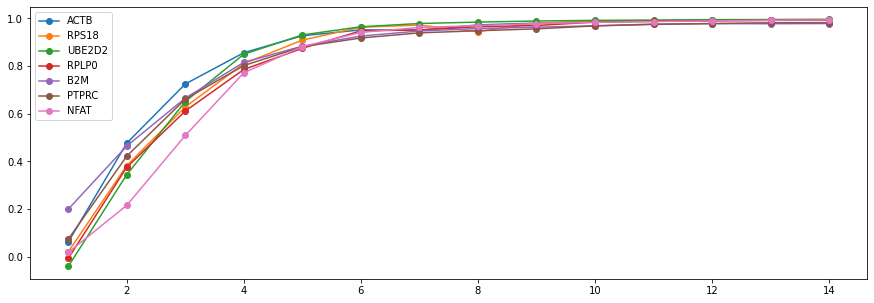

In [30]:
plt.plot([i for i in range(1, 15)], [toplot[i][0] for i in range(0,14)], label = housekeeping_genes[0], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][1] for i in range(0,14)], label = housekeeping_genes[1], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][2] for i in range(0,14)], label = housekeeping_genes[2], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][3] for i in range(0,14)], label = housekeeping_genes[3], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][4] for i in range(0,14)], label = housekeeping_genes[4], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][5] for i in range(0,14)], label = housekeeping_genes[5], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][6] for i in range(0,14)], label = "NFAT", marker='o')
plt.legend()

In [31]:
toplot = []
for i in range(15):
    print(i)
    if i >0:
        magic_operator.set_params(t = i)
        expression_magicked[genes] = magic_operator.transform(expression_log[genes], genes= "all_genes")
        expression_sc = expression_magicked
        split = train_test_split(expression_sc, test_size=0.1, random_state=2)
        expression_training_sc = split[0]
        expression_validation_sc = split[1]
    if i== 0:
        expression_sc = expression_log
        split = train_test_split(expression_sc, test_size=0.1, random_state=2)
        expression_training_sc = split[0]
        expression_validation_sc = split[1]
    
    to_plot_i = []
    
    for j in range(len(housekeeping_genes)):
        rf = LinearRegression()
        rf.fit(X = expression_training_sc[upstream_nodes_dict["NFAT"]], 
               y = expression_training_sc[housekeeping_genes[j]])

       
        to_plot_i.append(r2_score(y_true = expression_validation_sc[housekeeping_genes[j]], 
                                  y_pred = rf.predict(X = expression_validation_sc[upstream_nodes_dict["NFAT"]])))
   
    rf = LinearRegression()
    rf.fit(X = expression_training_sc[upstream_nodes_dict["NFAT"]], 
           y = expression_training_sc["NFAT"])

       
    to_plot_i.append(r2_score(y_true = expression_validation_sc["NFAT"], 
                              y_pred = rf.predict(X = expression_validation_sc[upstream_nodes_dict["NFAT"]])))
    toplot.append(to_plot_i)

0
1
Calculating imputation...
Calculated imputation in 0.03 seconds.
2
Calculating imputation...
Calculated imputation in 0.03 seconds.
3
Calculating imputation...
Calculated imputation in 0.04 seconds.
4
Calculating imputation...
Calculated imputation in 0.05 seconds.
5
Calculating imputation...
Calculated imputation in 0.07 seconds.
6
Calculating imputation...
Calculated imputation in 0.08 seconds.
7
Calculating imputation...
Calculated imputation in 0.10 seconds.
8
Calculating imputation...
Calculated imputation in 0.11 seconds.
9
Calculating imputation...
Calculated imputation in 0.12 seconds.
10
Calculating imputation...
Calculated imputation in 0.13 seconds.
11
Calculating imputation...
Calculated imputation in 0.15 seconds.
12
Calculating imputation...
Calculated imputation in 0.17 seconds.
13
Calculating imputation...
Calculated imputation in 0.17 seconds.
14
Calculating imputation...
Calculated imputation in 0.19 seconds.


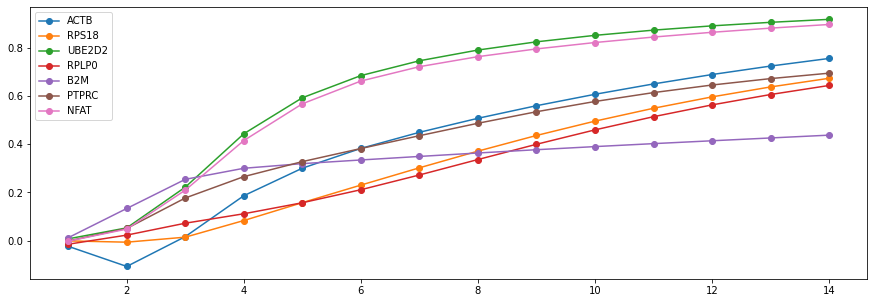

In [33]:
plt.plot([i for i in range(1, 15)], [toplot[i][0] for i in range(0,14)], label = housekeeping_genes[0], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][1] for i in range(0,14)], label = housekeeping_genes[1], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][2] for i in range(0,14)], label = housekeeping_genes[2], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][3] for i in range(0,14)], label = housekeeping_genes[3], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][4] for i in range(0,14)], label = housekeeping_genes[4], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][5] for i in range(0,14)], label = housekeeping_genes[5], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][6] for i in range(0,14)], label = "NFAT", marker='o')
plt.legend()

# Try the same thing with some more usptream genes

It could be that this strange thing is due to the confounding factor of TFs that could affect housekeeping genes.

Let us try with some protein genes, higher in the network

Lck is the childnode of CD45 and CD28

In [35]:
upstream_nodes_dict["Lck"] = ["CD45", "CD28"]

toplot = []
for i in range(1,15):
    print(i)

    if i >0:
        magic_operator.set_params(t = i)
        expression_magicked[genes] = magic_operator.transform(expression_log[genes], genes= "all_genes")
        expression_sc = expression_magicked
        split = train_test_split(expression_sc, test_size=0.1, random_state=2)
        expression_training_sc = split[0]
        expression_validation_sc = split[1]
    if i== 0:
        expression_sc = expression_log
        split = train_test_split(expression_sc, test_size=0.1, random_state=2)
        expression_training_sc = split[0]
        expression_validation_sc = split[1]
    
    to_plot_i = []
    
    for j in range(len(housekeeping_genes)):
        rf = RandomForestRegressor(random_state=2)
        rf.fit(X = expression_training_sc[upstream_nodes_dict["Lck"]], 
               y = expression_training_sc[housekeeping_genes[j]])

       
        to_plot_i.append(r2_score(y_true = expression_validation_sc[housekeeping_genes[j]], 
                                  y_pred = rf.predict(X = expression_validation_sc[upstream_nodes_dict["Lck"]])))
   
    rf = RandomForestRegressor(random_state=2)
    rf.fit(X = expression_training_sc[upstream_nodes_dict["Lck"]], 
           y = expression_training_sc["Lck"])

       
    to_plot_i.append(r2_score(y_true = expression_validation_sc["Lck"], 
                              y_pred = rf.predict(X = expression_validation_sc[upstream_nodes_dict["Lck"]])))
    toplot.append(to_plot_i)

1
Calculating imputation...
Calculated imputation in 0.02 seconds.
2
Calculating imputation...
Calculated imputation in 0.03 seconds.
3
Calculating imputation...
Calculated imputation in 0.04 seconds.
4
Calculating imputation...
Calculated imputation in 0.06 seconds.
5
Calculating imputation...
Calculated imputation in 0.07 seconds.
6
Calculating imputation...
Calculated imputation in 0.09 seconds.
7
Calculating imputation...
Calculated imputation in 0.10 seconds.
8
Calculating imputation...
Calculated imputation in 0.12 seconds.
9
Calculating imputation...
Calculated imputation in 0.13 seconds.
10
Calculating imputation...
Calculated imputation in 0.15 seconds.
11
Calculating imputation...
Calculated imputation in 0.16 seconds.
12
Calculating imputation...
Calculated imputation in 0.18 seconds.
13
Calculating imputation...
Calculated imputation in 0.19 seconds.
14
Calculating imputation...
Calculated imputation in 0.21 seconds.


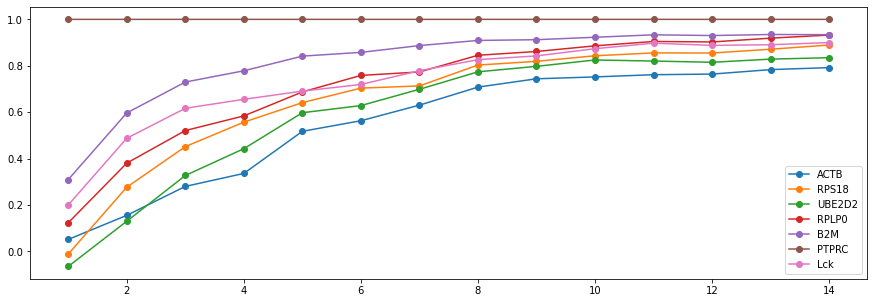

In [36]:
plt.plot([i for i in range(1, 15)], [toplot[i][0] for i in range(0,14)], label = housekeeping_genes[0], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][1] for i in range(0,14)], label = housekeeping_genes[1], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][2] for i in range(0,14)], label = housekeeping_genes[2], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][3] for i in range(0,14)], label = housekeeping_genes[3], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][4] for i in range(0,14)], label = housekeeping_genes[4], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][5] for i in range(0,14)], label = housekeeping_genes[5], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][6] for i in range(0,14)], label = "Lck", marker='o')
plt.legend()

In [37]:
toplot = []
for i in range(15):
    print(i)
    if i >0:
        magic_operator.set_params(t = i)
        expression_magicked[genes] = magic_operator.transform(expression_log[genes], genes= "all_genes")
        expression_sc = expression_magicked
        split = train_test_split(expression_sc, test_size=0.1, random_state=2)
        expression_training_sc = split[0]
        expression_validation_sc = split[1]
    if i== 0:
        expression_sc = expression_log
        split = train_test_split(expression_sc, test_size=0.1, random_state=2)
        expression_training_sc = split[0]
        expression_validation_sc = split[1]
    
    to_plot_i = []
    
    for j in range(len(housekeeping_genes)):
        rf = LinearRegression()
        rf.fit(X = expression_training_sc[upstream_nodes_dict["Lck"]], 
               y = expression_training_sc[housekeeping_genes[j]])

       
        to_plot_i.append(r2_score(y_true = expression_validation_sc[housekeeping_genes[j]], 
                                  y_pred = rf.predict(X = expression_validation_sc[upstream_nodes_dict["Lck"]])))
   
    rf = LinearRegression()
    rf.fit(X = expression_training_sc[upstream_nodes_dict["Lck"]], 
           y = expression_training_sc["Lck"])

       
    to_plot_i.append(r2_score(y_true = expression_validation_sc["Lck"], 
                              y_pred = rf.predict(X = expression_validation_sc[upstream_nodes_dict["Lck"]])))
    toplot.append(to_plot_i)

0
1
Calculating imputation...
Calculated imputation in 0.02 seconds.
2
Calculating imputation...
Calculated imputation in 0.03 seconds.
3
Calculating imputation...
Calculated imputation in 0.04 seconds.
4
Calculating imputation...
Calculated imputation in 0.05 seconds.
5
Calculating imputation...
Calculated imputation in 0.07 seconds.
6
Calculating imputation...
Calculated imputation in 0.08 seconds.
7
Calculating imputation...
Calculated imputation in 0.10 seconds.
8
Calculating imputation...
Calculated imputation in 0.11 seconds.
9
Calculating imputation...
Calculated imputation in 0.13 seconds.
10
Calculating imputation...
Calculated imputation in 0.13 seconds.
11
Calculating imputation...
Calculated imputation in 0.15 seconds.
12
Calculating imputation...
Calculated imputation in 0.16 seconds.
13
Calculating imputation...
Calculated imputation in 0.17 seconds.
14
Calculating imputation...
Calculated imputation in 0.19 seconds.


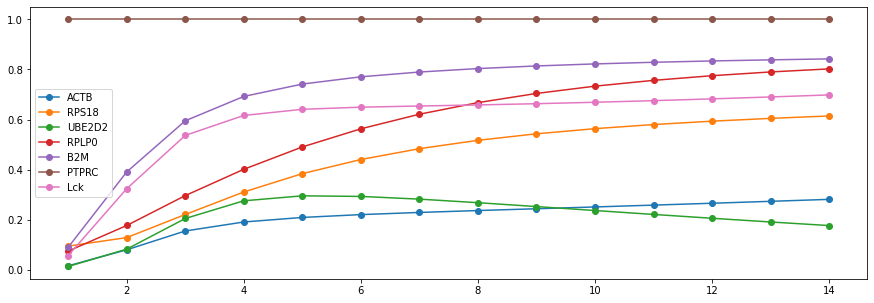

In [38]:
plt.plot([i for i in range(1, 15)], [toplot[i][0] for i in range(0,14)], label = housekeeping_genes[0], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][1] for i in range(0,14)], label = housekeeping_genes[1], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][2] for i in range(0,14)], label = housekeeping_genes[2], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][3] for i in range(0,14)], label = housekeeping_genes[3], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][4] for i in range(0,14)], label = housekeeping_genes[4], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][5] for i in range(0,14)], label = housekeeping_genes[5], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][6] for i in range(0,14)], label = "Lck", marker='o')
plt.legend()

In [39]:
upstream_nodes_dict["Grb2"] = ["CD3z", "CD28", "Shc"]

toplot = []
for i in range(1,15):
    print(i)

    if i >0:
        magic_operator.set_params(t = i)
        expression_magicked[genes] = magic_operator.transform(expression_log[genes], genes= "all_genes")
        expression_sc = expression_magicked
        split = train_test_split(expression_sc, test_size=0.1, random_state=2)
        expression_training_sc = split[0]
        expression_validation_sc = split[1]
    if i== 0:
        expression_sc = expression_log
        split = train_test_split(expression_sc, test_size=0.1, random_state=2)
        expression_training_sc = split[0]
        expression_validation_sc = split[1]
    
    to_plot_i = []
    
    for j in range(len(housekeeping_genes)):
        rf = RandomForestRegressor(random_state=2)
        rf.fit(X = expression_training_sc[upstream_nodes_dict["Grb2"]], 
               y = expression_training_sc[housekeeping_genes[j]])

       
        to_plot_i.append(r2_score(y_true = expression_validation_sc[housekeeping_genes[j]], 
                                  y_pred = rf.predict(X = expression_validation_sc[upstream_nodes_dict["Grb2"]])))
   
    rf = RandomForestRegressor(random_state=2)
    rf.fit(X = expression_training_sc[upstream_nodes_dict["Grb2"]], 
           y = expression_training_sc["Grb2"])

       
    to_plot_i.append(r2_score(y_true = expression_validation_sc["Grb2"], 
                              y_pred = rf.predict(X = expression_validation_sc[upstream_nodes_dict["Grb2"]])))
    toplot.append(to_plot_i)

1


NameError: name 'magic_operator' is not defined

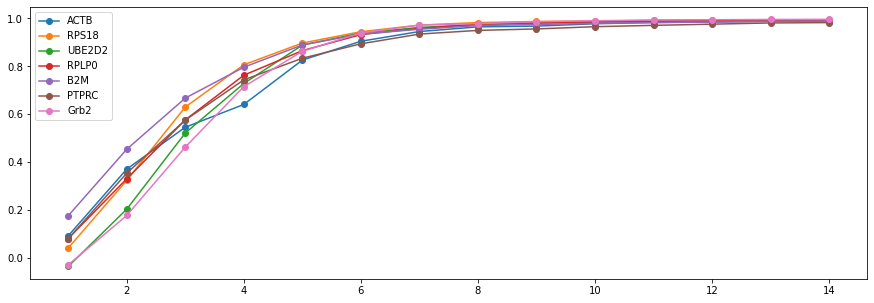

In [40]:
plt.plot([i for i in range(1, 15)], [toplot[i][0] for i in range(0,14)], label = housekeeping_genes[0], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][1] for i in range(0,14)], label = housekeeping_genes[1], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][2] for i in range(0,14)], label = housekeeping_genes[2], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][3] for i in range(0,14)], label = housekeeping_genes[3], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][4] for i in range(0,14)], label = housekeeping_genes[4], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][5] for i in range(0,14)], label = housekeeping_genes[5], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][6] for i in range(0,14)], label = "Grb2", marker='o')
plt.legend()

In [41]:
toplot = []
for i in range(15):
    print(i)
    if i >0:
        magic_operator.set_params(t = i)
        expression_magicked[genes] = magic_operator.transform(expression_log[genes], genes= "all_genes")
        expression_sc = expression_magicked
        split = train_test_split(expression_sc, test_size=0.1, random_state=2)
        expression_training_sc = split[0]
        expression_validation_sc = split[1]
    if i== 0:
        expression_sc = expression_log
        split = train_test_split(expression_sc, test_size=0.1, random_state=2)
        expression_training_sc = split[0]
        expression_validation_sc = split[1]
    
    to_plot_i = []
    
    for j in range(len(housekeeping_genes)):
        rf = LinearRegression()
        rf.fit(X = expression_training_sc[upstream_nodes_dict["Grb2"]], 
               y = expression_training_sc[housekeeping_genes[j]])

       
        to_plot_i.append(r2_score(y_true = expression_validation_sc[housekeeping_genes[j]], 
                                  y_pred = rf.predict(X = expression_validation_sc[upstream_nodes_dict["Grb2"]])))
   
    rf = LinearRegression()
    rf.fit(X = expression_training_sc[upstream_nodes_dict["Grb2"]], 
           y = expression_training_sc["Grb2"])

       
    to_plot_i.append(r2_score(y_true = expression_validation_sc["Grb2"], 
                              y_pred = rf.predict(X = expression_validation_sc[upstream_nodes_dict["Grb2"]])))
    toplot.append(to_plot_i)

0
1
Calculating imputation...
Calculated imputation in 0.02 seconds.
2
Calculating imputation...
Calculated imputation in 0.03 seconds.
3
Calculating imputation...
Calculated imputation in 0.04 seconds.
4
Calculating imputation...
Calculated imputation in 0.06 seconds.
5
Calculating imputation...
Calculated imputation in 0.08 seconds.
6
Calculating imputation...
Calculated imputation in 0.09 seconds.
7
Calculating imputation...
Calculated imputation in 0.10 seconds.
8
Calculating imputation...
Calculated imputation in 0.12 seconds.
9
Calculating imputation...
Calculated imputation in 0.13 seconds.
10
Calculating imputation...
Calculated imputation in 0.14 seconds.
11
Calculating imputation...
Calculated imputation in 0.16 seconds.
12
Calculating imputation...
Calculated imputation in 0.17 seconds.
13
Calculating imputation...
Calculated imputation in 0.19 seconds.
14
Calculating imputation...
Calculated imputation in 0.20 seconds.


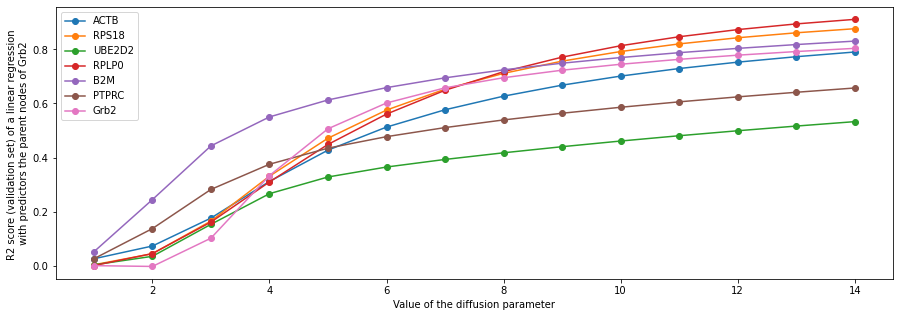

In [46]:
plt.plot([i for i in range(1, 15)], [toplot[i][0] for i in range(0,14)], label = housekeeping_genes[0], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][1] for i in range(0,14)], label = housekeeping_genes[1], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][2] for i in range(0,14)], label = housekeeping_genes[2], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][3] for i in range(0,14)], label = housekeeping_genes[3], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][4] for i in range(0,14)], label = housekeeping_genes[4], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][5] for i in range(0,14)], label = housekeeping_genes[5], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][6] for i in range(0,14)], label = "Grb2", marker='o')
plt.xlabel("Value of the diffusion parameter")
plt.ylabel("R2 score (validation set) of a linear regression \n with predictors the parent nodes of Grb2 ")
plt.legend()

In [47]:
upstream_nodes_dict["TRAF2"] = ["CD40", "41BB"]

toplot = []
for i in range(1,15):
    print(i)

    if i >0:
        magic_operator.set_params(t = i)
        expression_magicked[genes] = magic_operator.transform(expression_log[genes], genes= "all_genes")
        expression_sc = expression_magicked
        split = train_test_split(expression_sc, test_size=0.1, random_state=2)
        expression_training_sc = split[0]
        expression_validation_sc = split[1]
    if i== 0:
        expression_sc = expression_log
        split = train_test_split(expression_sc, test_size=0.1, random_state=2)
        expression_training_sc = split[0]
        expression_validation_sc = split[1]
    
    to_plot_i = []
    
    for j in range(len(housekeeping_genes)):
        rf = RandomForestRegressor(random_state=2)
        rf.fit(X = expression_training_sc[upstream_nodes_dict["TRAF2"]], 
               y = expression_training_sc[housekeeping_genes[j]])

       
        to_plot_i.append(r2_score(y_true = expression_validation_sc[housekeeping_genes[j]], 
                                  y_pred = rf.predict(X = expression_validation_sc[upstream_nodes_dict["TRAF2"]])))
   
    rf = RandomForestRegressor(random_state=2)
    rf.fit(X = expression_training_sc[upstream_nodes_dict["TRAF2"]], 
           y = expression_training_sc["TRAF2"])

       
    to_plot_i.append(r2_score(y_true = expression_validation_sc["TRAF2"], 
                              y_pred = rf.predict(X = expression_validation_sc[upstream_nodes_dict["TRAF2"]])))
    toplot.append(to_plot_i)

1
Calculating imputation...
Calculated imputation in 0.02 seconds.
2
Calculating imputation...
Calculated imputation in 0.04 seconds.


KeyboardInterrupt: 

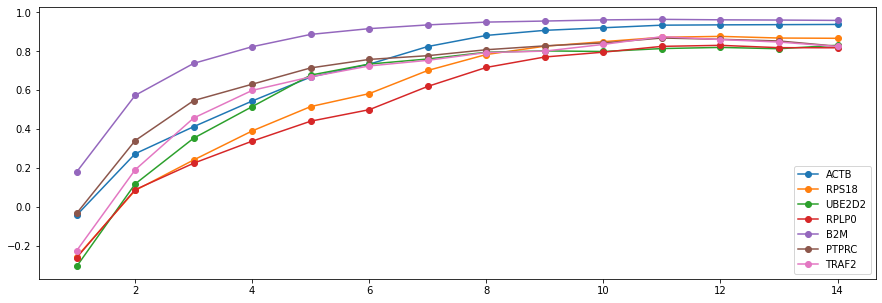

In [44]:
plt.plot([i for i in range(1, 15)], [toplot[i][0] for i in range(0,14)], label = housekeeping_genes[0], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][1] for i in range(0,14)], label = housekeeping_genes[1], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][2] for i in range(0,14)], label = housekeeping_genes[2], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][3] for i in range(0,14)], label = housekeeping_genes[3], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][4] for i in range(0,14)], label = housekeeping_genes[4], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][5] for i in range(0,14)], label = housekeeping_genes[5], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][6] for i in range(0,14)], label = "TRAF2", marker='o')
plt.legend()

In [48]:
toplot = []
for i in range(15):
    print(i)
    if i >0:
        magic_operator.set_params(t = i)
        expression_magicked[genes] = magic_operator.transform(expression_log[genes], genes= "all_genes")
        expression_sc = expression_magicked
        split = train_test_split(expression_sc, test_size=0.1, random_state=2)
        expression_training_sc = split[0]
        expression_validation_sc = split[1]
    if i== 0:
        expression_sc = expression_log
        split = train_test_split(expression_sc, test_size=0.1, random_state=2)
        expression_training_sc = split[0]
        expression_validation_sc = split[1]
    
    to_plot_i = []
    
    for j in range(len(housekeeping_genes)):
        rf = LinearRegression()
        rf.fit(X = expression_training_sc[upstream_nodes_dict["TRAF2"]], 
               y = expression_training_sc[housekeeping_genes[j]])

       
        to_plot_i.append(r2_score(y_true = expression_validation_sc[housekeeping_genes[j]], 
                                  y_pred = rf.predict(X = expression_validation_sc[upstream_nodes_dict["TRAF2"]])))
   
    rf = LinearRegression()
    rf.fit(X = expression_training_sc[upstream_nodes_dict["TRAF2"]], 
           y = expression_training_sc["TRAF2"])

       
    to_plot_i.append(r2_score(y_true = expression_validation_sc["TRAF2"], 
                              y_pred = rf.predict(X = expression_validation_sc[upstream_nodes_dict["TRAF2"]])))
    toplot.append(to_plot_i)

0
1
Calculating imputation...
Calculated imputation in 0.02 seconds.
2
Calculating imputation...
Calculated imputation in 0.03 seconds.
3
Calculating imputation...
Calculated imputation in 0.04 seconds.
4
Calculating imputation...
Calculated imputation in 0.06 seconds.
5
Calculating imputation...
Calculated imputation in 0.08 seconds.
6
Calculating imputation...
Calculated imputation in 0.09 seconds.
7
Calculating imputation...
Calculated imputation in 0.10 seconds.
8
Calculating imputation...
Calculated imputation in 0.11 seconds.
9
Calculating imputation...
Calculated imputation in 0.13 seconds.
10
Calculating imputation...
Calculated imputation in 0.15 seconds.
11
Calculating imputation...
Calculated imputation in 0.16 seconds.
12
Calculating imputation...
Calculated imputation in 0.17 seconds.
13
Calculating imputation...
Calculated imputation in 0.18 seconds.
14
Calculating imputation...
Calculated imputation in 0.20 seconds.


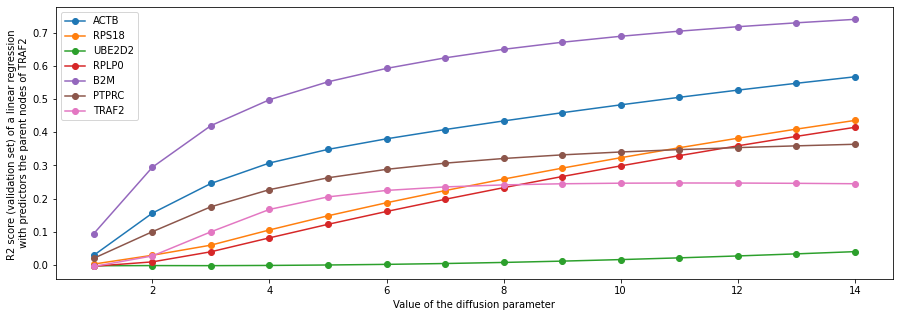

In [49]:
plt.plot([i for i in range(1, 15)], [toplot[i][0] for i in range(0,14)], label = housekeeping_genes[0], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][1] for i in range(0,14)], label = housekeeping_genes[1], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][2] for i in range(0,14)], label = housekeeping_genes[2], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][3] for i in range(0,14)], label = housekeeping_genes[3], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][4] for i in range(0,14)], label = housekeeping_genes[4], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][5] for i in range(0,14)], label = housekeeping_genes[5], marker='o')
plt.plot([i for i in range(1, 15)], [toplot[i][6] for i in range(0,14)], label = "TRAF2", marker='o')
plt.xlabel("Value of the diffusion parameter")
plt.ylabel("R2 score (validation set) of a linear regression \n with predictors the parent nodes of TRAF2 ")
plt.legend()

# Using silhouette scores as a marker

In [15]:
import sklearn

In [29]:
S_scores = []
S_scores.append(sklearn.metrics.silhouette_score(expression_log[genes], labels = expression_log["cell_type"], metric='euclidean'))

for i in range(1,20):
    magic_operator.set_params(t = i)
    expression_magicked[genes] = magic_operator.transform(expression_log[genes], genes= "all_genes")
    expression_sc = expression_magicked
    S_scores.append(sklearn.metrics.silhouette_score(expression_magicked[genes],
                                                     labels = expression_magicked["cell_type"], metric='euclidean'))



Calculating imputation...
Calculated imputation in 0.02 seconds.
Calculating imputation...
Calculated imputation in 0.03 seconds.
Calculating imputation...
Calculated imputation in 0.05 seconds.
Calculating imputation...
Calculated imputation in 0.06 seconds.
Calculating imputation...
Calculated imputation in 0.07 seconds.
Calculating imputation...
Calculated imputation in 0.09 seconds.
Calculating imputation...
Calculated imputation in 0.10 seconds.
Calculating imputation...
Calculated imputation in 0.12 seconds.
Calculating imputation...
Calculated imputation in 0.13 seconds.
Calculating imputation...
Calculated imputation in 0.15 seconds.
Calculating imputation...
Calculated imputation in 0.16 seconds.
Calculating imputation...
Calculated imputation in 0.18 seconds.
Calculating imputation...
Calculated imputation in 0.19 seconds.
Calculating imputation...
Calculated imputation in 0.20 seconds.
Calculating imputation...
Calculated imputation in 0.22 seconds.
Calculating imputation...

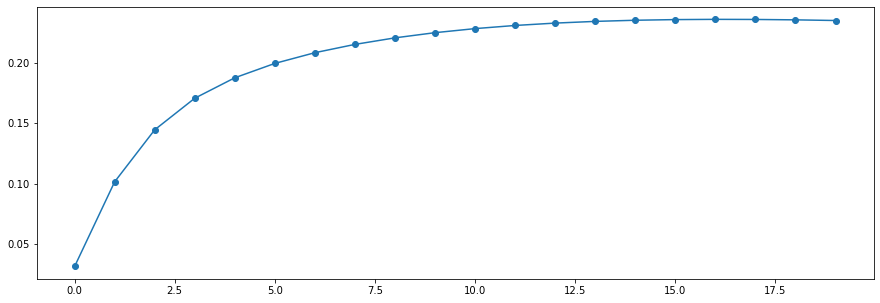

In [30]:
plt.plot([i for i in range(20)], S_scores, marker = "o")

 The Silhouette score is better for t~3